Here, we have data for NVE simulations of rigid bumpy particles of various $\mu_{eff}$ and $N_v$ across a range of $\phi$, starting at a dilute region and going beyond jamming.  Each NVE run is performed consecutively, starting from the lowest $\phi$ and incrementally compressing using a simple rescaling thermostat to enforce the temperature.  The particles are compressed and thermostatted for $N_{steps}/20$ and are allowed to thermally equilibrate under the thermostat for another $N_{steps}/20$.  Following this, the thermostat is turned off, and the NVE dynamics progress for $N_{steps}$.  We then measure the translational and rotational diffusion coefficients (using the MSD and MSAD), the structural relaxation times (using the self-part of the ISF and the rotational ISF), and the location of the first peak in the radial distribution function.  The measurements were performed in the Hard Particle (HP) limit, such that time-dependent quantities can be simply rescaled by $t \sqrt{T}$.

There are two sets of runs here.  One was performed at a higher temperature (I believe, $T=10^{-4}$) using the old method for calculating the moment of inertia.  The other was at $T=10^{-6}$ and uses the new method for the moment of inertia.  The new data is the one to pay attention to.

Here, we will plot the $\phi$, $\mu_{eff}$, and $N_v$ dependence of the dynamic and structural quantities of interest.

In [2]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm

def fit_log(_x, _y, n=1, min_cut_pct=None, max_cut_pct=None):
    mask = np.ones(_x.shape[0], dtype=bool)
    if min_cut_pct:
        mask &= (_x >= min_cut_pct * _x.max())
    if max_cut_pct:
        mask &= (_x <= max_cut_pct * _x.max())
    x = np.log10(_x[mask])
    y = np.log10(_y[mask])
    # fit the exponent
    n_measured, log_d = np.polyfit(x, y, 1)
    if n is None:
        d = 10 ** log_d
        y_pred = n_measured * x + log_d
    else:
        # fit the prefactor using the assumed exponent
        def obj(b, x, y):
            return np.sum((y - (n * x + b)) ** 2)
        log_d = minimize(obj, log_d, args=(x, y)).x[0]
        d = 10 ** log_d
        y_pred = n * x + log_d
    r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
    return d, n_measured, r2

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def get_peak_location(r, g, window_pct=0.99):
    mask = g >= np.max(g) * window_pct
    return np.mean(r[mask])


In [3]:
root = '/Users/marshallmccraw/Projects/yale/data/s-25/10-02-25/grace-data/'

hot_dir = os.path.join(root, 'rb-compression-diffusion')
cold_dir = os.path.join(root, 'rb-compression-diffusion-lower-temp')

In [4]:
# dirname = hot_dir
# dt = 1e-2
# T = 1e-4
dirname = cold_dir
dt = 5e-2
T = 1e-6

system_data = {
    'phi': [],
    'D': [],
    'n': [],
    'R2': [],
    'D_R': [],
    'n_R': [],
    'R2_R': [],
    'tau_small': [],
    'tau_R_small': [],
    'tau_large': [],
    'tau_R_large': [],
    'r0_small': [],
    'r0_large': [],
    'nv': [],
    'mu_eff': [],
    'pressure': [],
    'temperature': [],
    'file_name': [],
    'file_mu_route': []
}

time_dependent_data = {
    'phi': [],
    'nv': [],
    'mu_eff': [],
    'msd': [],
    'msad': [],
    'isf_small': [],
    'isf_large': [],
    'aisf_small': [],
    'aisf_large': [],
    't': []
}

for friction_coefficient in os.listdir(dirname):
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        data = dp.data.load(run_path, location=['final', 'init'])
        data.calculate_mu_eff()

        m = data.final.msd[:, :, 0]
        am = data.final.msd[:, :, 1]
        isf_small = data.final.isf[:, 0, :]
        isf_large = data.final.isf[:, 1, :]
        aisf_small = data.final.angular_isf[:, 0, :]
        aisf_large = data.final.angular_isf[:, 1, :]
        t = data.final.t * dt * np.sqrt(T)
        g_small = data.final.g[:, 0, :].T
        g_large = data.final.g[:, 1, :].T
        r = data.final.r

        p = data.final.mean_pressure
        temp = data.final.mean_temperature

        for sid in range(data.n_systems()):
            _m = m[:, sid]
            D, n, R2 = fit_log(t, _m, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            # plt.plot(t, _m)
            # plt.plot(t, D * t ** 1)

            _am = am[:, sid]
            D_R, n_R, R2_R = fit_log(t, _am, n=1, min_cut_pct=0.1, max_cut_pct=0.9)
            # plt.plot(t, _am)
            # plt.plot(t, D_R * t ** 1)

            _isf_small = isf_small[:, sid]
            tau_small = get_relaxation_time(_isf_small, t)
            # plt.plot(t, _isf)
            # plt.axvline(tau, color='k', linestyle='--')

            _isf_large = isf_large[:, sid]
            tau_large = get_relaxation_time(_isf_large, t)
            # plt.plot(t, _isf_large)
            # plt.axvline(tau_large, color='k', linestyle='--')
            # use tau to override D (if it is nan, D is nan)
            if np.isnan(tau_small) or np.isnan(tau_large):
                D = np.nan

            _aisf_small = aisf_small[:, sid]
            tau_R_small = get_relaxation_time(_aisf_small, t)
            # plt.plot(t, _aisf)
            # plt.axvline(tau_R, color='k', linestyle='--')

            _aisf_large = aisf_large[:, sid]
            tau_R_large = get_relaxation_time(_aisf_large, t)
            # plt.plot(t, _aisf_large)
            # plt.axvline(tau_R_large, color='k', linestyle='--')

            # use tau_R to override D_R (if it is nan, D_R is nan)
            if np.isnan(tau_R_small) or np.isnan(tau_R_large):
                D_R = np.nan

            _g_small = g_small[:, sid]
            r0_small = get_peak_location(r, _g_small, window_pct=0.99)
            # plt.plot(r, _g_small)
            # plt.scatter(r0_small, np.max(_g_small), color='k')

            _g_large = g_large[:, sid]
            r0_large = get_peak_location(r, _g_large, window_pct=0.99)
            # plt.plot(r, _g_large)
            # plt.scatter(r0_large, np.max(_g_large), color='k')

            system_data['phi'].append(data.packing_fraction[sid])
            system_data['D'].append(D)
            system_data['n'].append(n)
            system_data['R2'].append(R2)
            system_data['D_R'].append(D_R)
            system_data['n_R'].append(n_R)
            system_data['R2_R'].append(R2_R)
            system_data['tau_small'].append(tau_small)
            system_data['tau_R_small'].append(tau_R_small)
            system_data['tau_large'].append(tau_large)
            system_data['tau_R_large'].append(tau_R_large)
            system_data['r0_small'].append(r0_small)
            system_data['r0_large'].append(r0_large)
            system_data['nv'].append(data.n_vertices_per_particle[data.system_offset[sid]])
            system_data['mu_eff'].append(data.mu_eff[data.system_offset[sid]])
            system_data['pressure'].append(p[sid])
            system_data['temperature'].append(temp[sid])
            system_data['file_name'].append(os.path.basename(run_path))
            system_data['file_mu_route'].append(os.path.basename(os.path.dirname(run_path)).split('-')[-1])

            time_dependent_data['phi'].append(data.packing_fraction[sid])
            time_dependent_data['nv'].append(data.n_vertices_per_particle[data.system_offset[sid]])
            time_dependent_data['mu_eff'].append(data.mu_eff[data.system_offset[sid]])
            time_dependent_data['msd'].append(m[:, sid])
            time_dependent_data['msad'].append(am[:, sid])
            time_dependent_data['isf_small'].append(isf_small[:, sid])
            time_dependent_data['isf_large'].append(isf_large[:, sid])
            time_dependent_data['aisf_small'].append(aisf_small[:, sid])
            time_dependent_data['aisf_large'].append(aisf_large[:, sid])
            time_dependent_data['t'].append(t)

system_data = pd.DataFrame(system_data)

time_dependent_data = {k: np.array(v) for k, v in time_dependent_data.items()}

In [5]:
effective_geom_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/effective-diameter/effective_geometry_data.csv')
trans_phi_c_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/trans_phi_c_data.csv')
rot_phi_c_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/rot_phi_c_data.csv')
phi_j_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/analyzing-data-from-cluster/jamming/phi_j_data.csv')

# Maximum 0-Overlap Density

For each run, minimize the energy of the final trajectory step and record the potential energy per particle.  If a ~0 energy configuration is achievable, the density of the run is valid - the run corresponds to a valid hard particle system.  Otherwise, overlaps are innevitable and the density isn't something we should be particularly interested in.

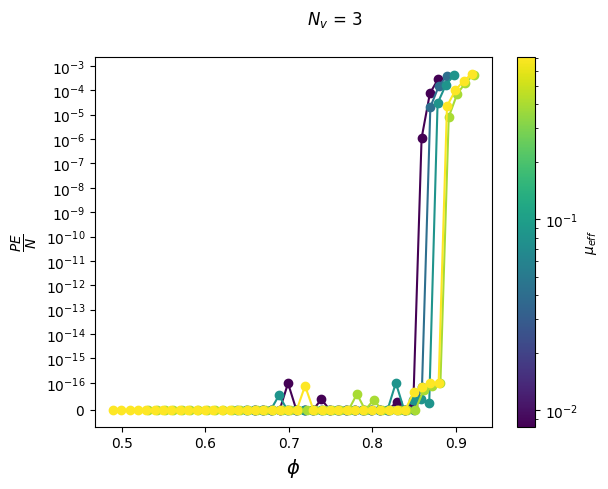

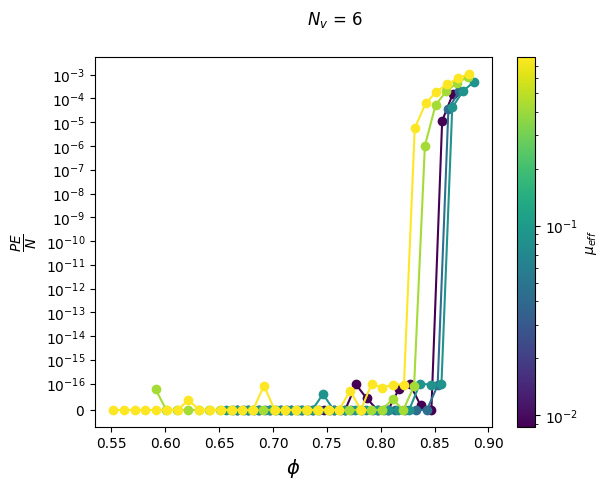

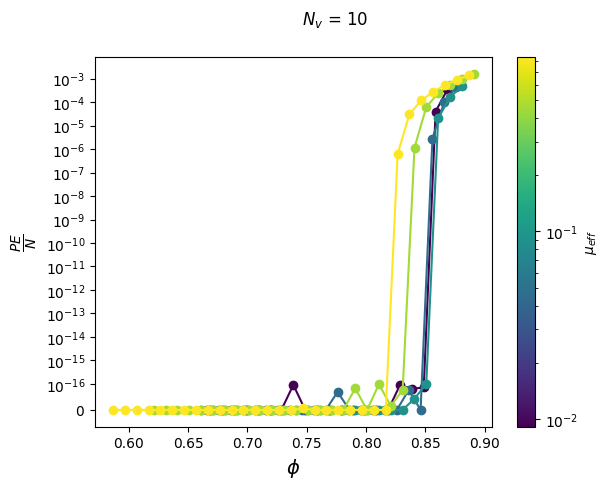

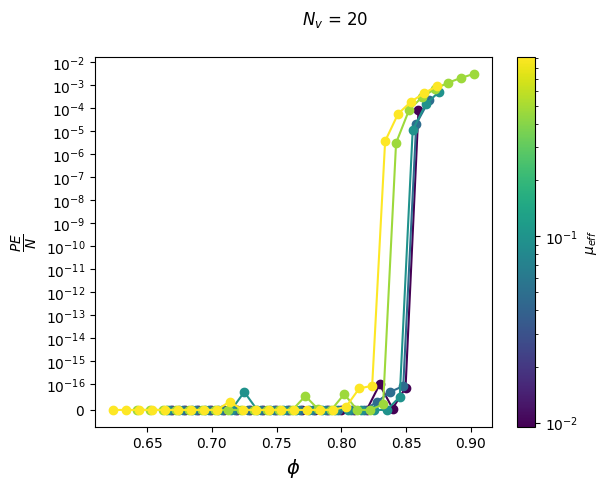

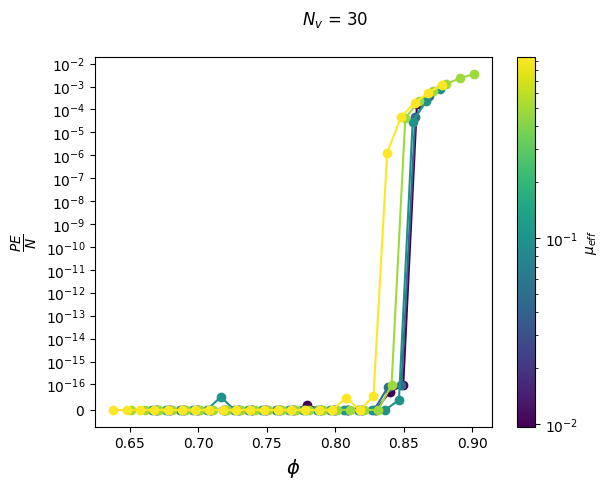

In [6]:
zero_overlap_cutoff = 1e-14  # pe/particle exceeding this value indicates overlap

minimized_data = {
    'phi': [],
    'nv': [],
    'mu_eff': [],
    'avg_pe': [],
}

for friction_coefficient in os.listdir(dirname)[::-1]:
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        pressure_path = os.path.join(friction_dir, f'minimized_{file_index}')
        if not os.path.exists(os.path.join(pressure_path, 'meta.h5')):
            continue
        data = dp.data.load(pressure_path, location=['final', 'init'])
        if len(data.final.arrays.keys()) == 0:
            continue
        data.calculate_mu_eff()

        pe_total = data.final.pe_total / data.system_size
        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu_eff = data.mu_eff[data.system_offset[:-1]]
        phi = data.packing_fraction

        minimized_data['phi'].extend(phi)
        minimized_data['nv'].extend(nv)
        minimized_data['mu_eff'].extend(mu_eff)
        minimized_data['avg_pe'].extend(pe_total)

minimized_data = pd.DataFrame(minimized_data)

max_overlap_data = {
    'phi_max': [],
    'nv': [],
    'mu_eff': [],
}

for nv in np.unique(minimized_data.nv):
    mask = minimized_data.nv == nv
    cmap = plt.cm.viridis
    mu_eff_values = np.unique(minimized_data.mu_eff[mask])
    mu_eff_norm = LogNorm(vmin=mu_eff_values.min(), vmax=mu_eff_values.max())
    for mu_eff in mu_eff_values:
        mask2 = mask & (minimized_data.mu_eff == mu_eff)
        plt.plot(minimized_data.phi[mask2], minimized_data.avg_pe[mask2], c=cmap(mu_eff_norm(mu_eff)), marker='o')
        if np.any(minimized_data.avg_pe[mask2] > zero_overlap_cutoff):
            phi_max = np.max(minimized_data.phi[mask2].values[minimized_data.avg_pe[mask2] < zero_overlap_cutoff])
        else:
            phi_max = np.inf
        max_overlap_data['phi_max'].append(phi_max)
        max_overlap_data['nv'].append(nv)
        max_overlap_data['mu_eff'].append(mu_eff)
    plt.yscale('symlog', linthresh=1e-16)
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.ylabel(r'$\frac{PE}{N}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.show()

max_overlap_data = pd.DataFrame(max_overlap_data)

# Dynamics

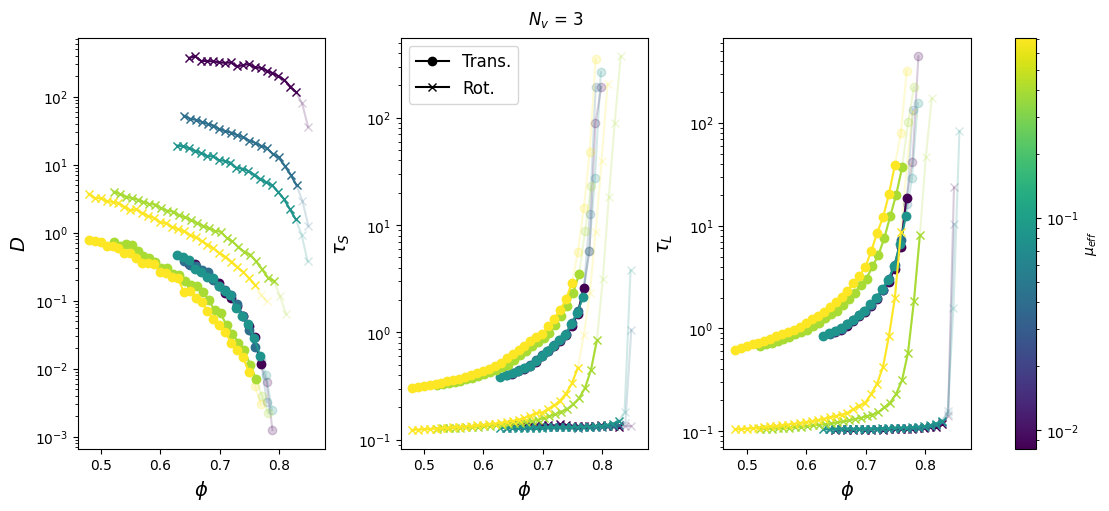

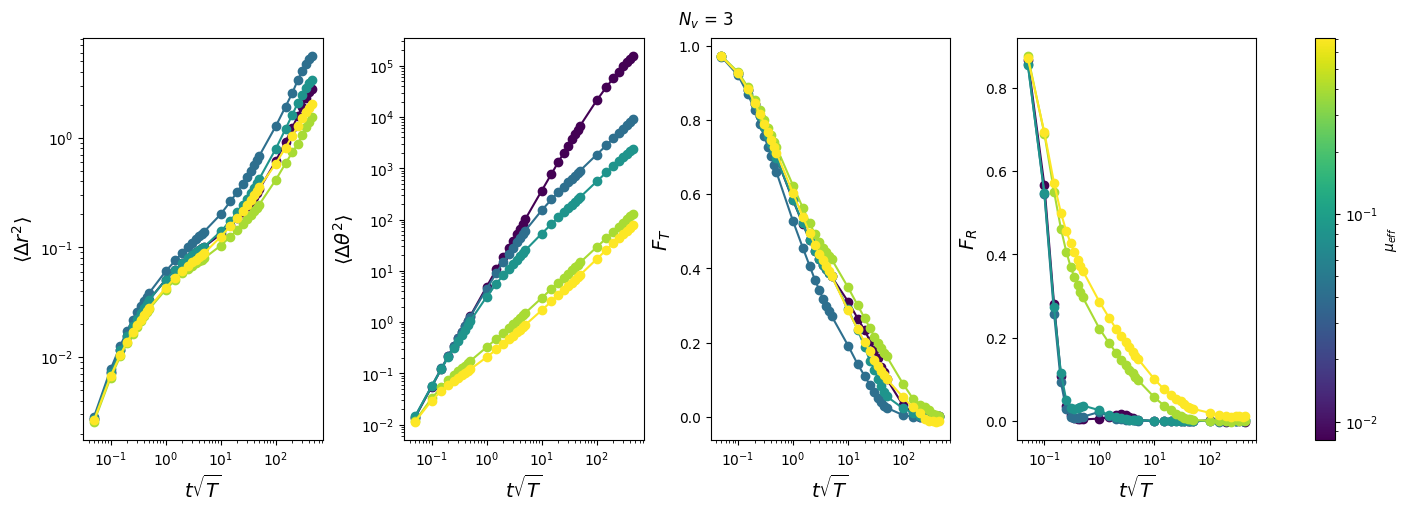

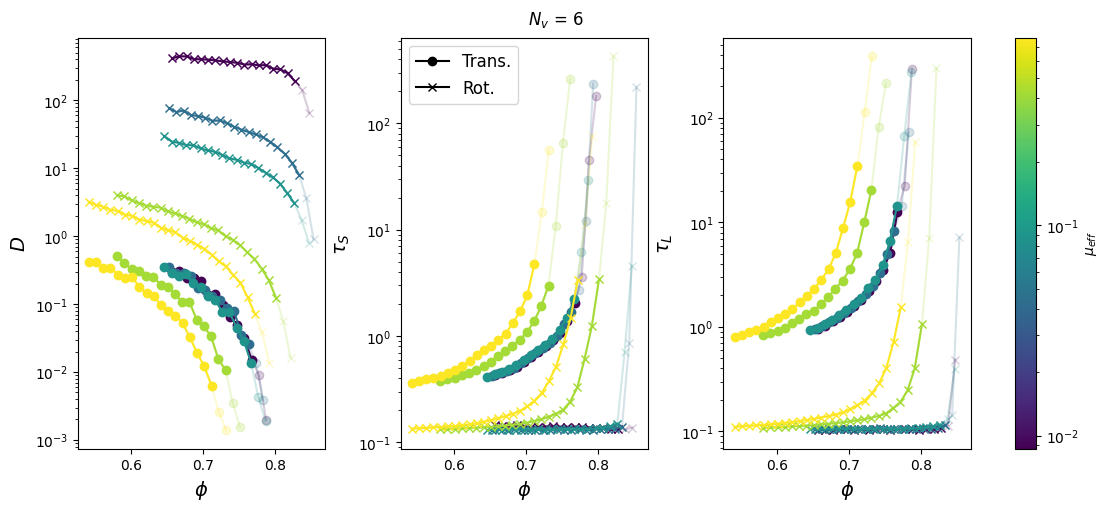

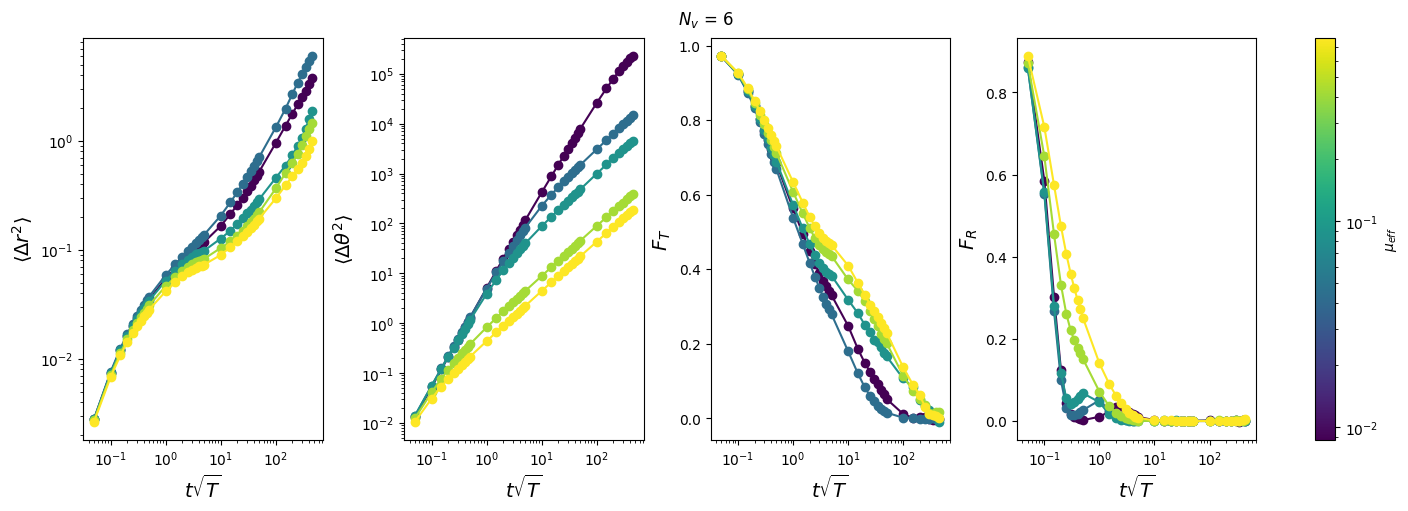

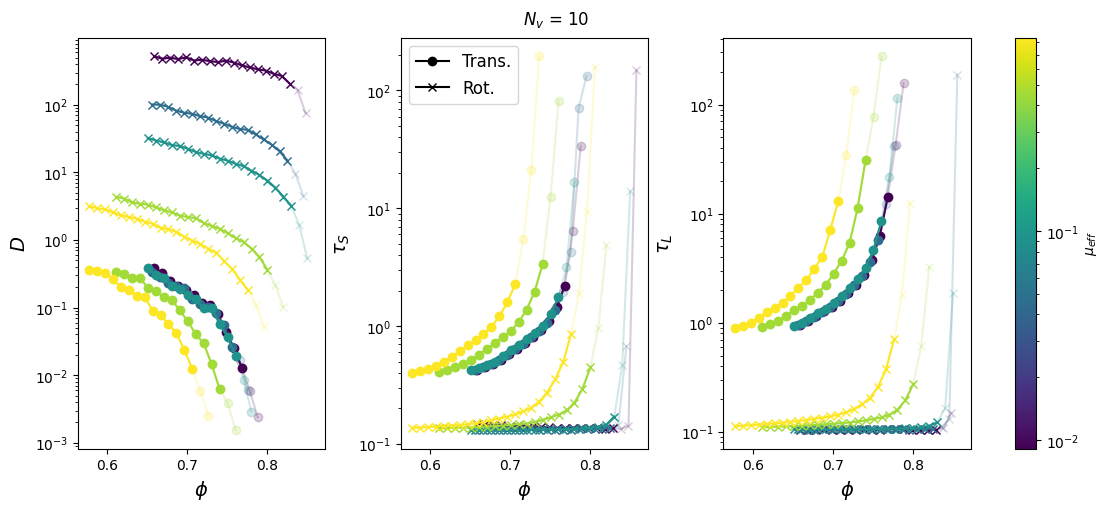

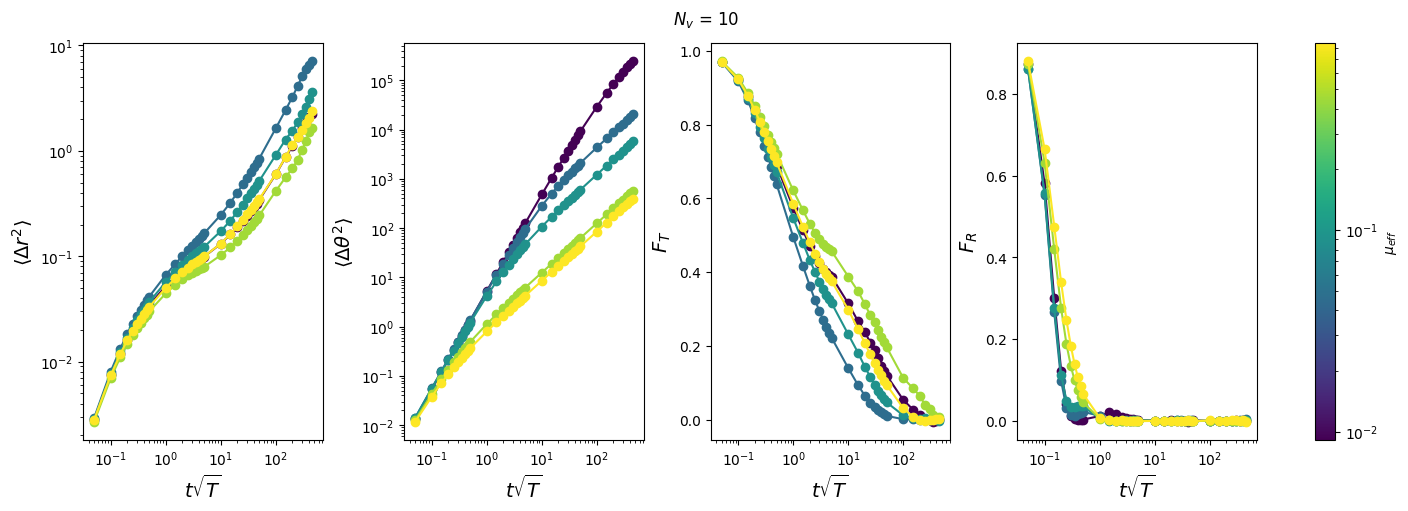

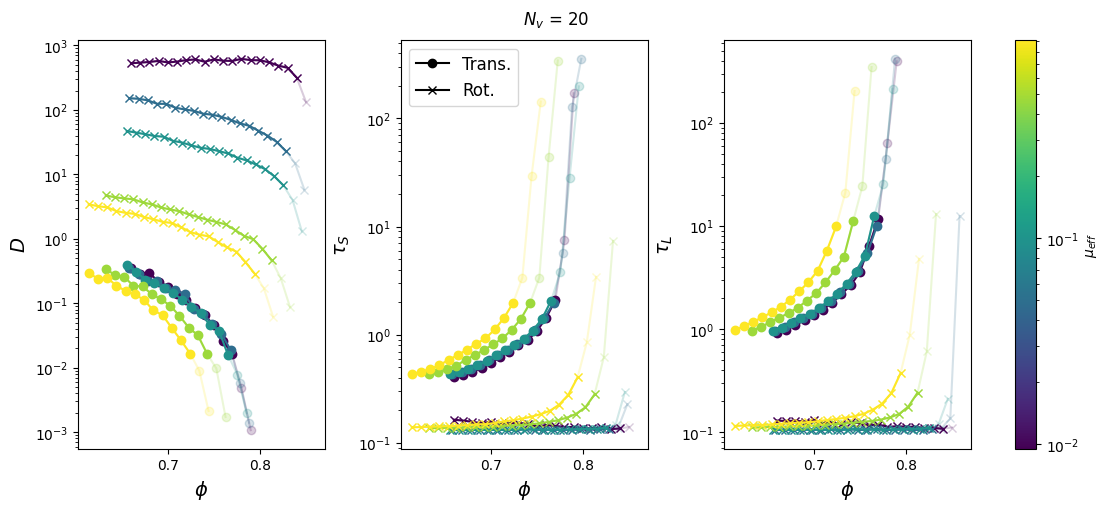

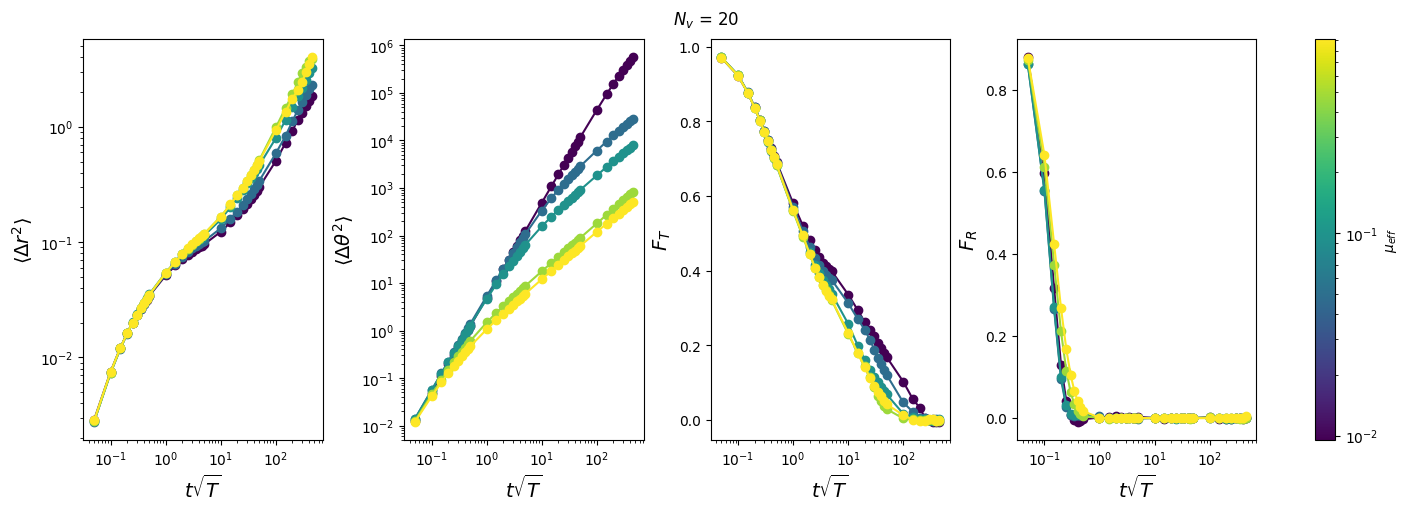

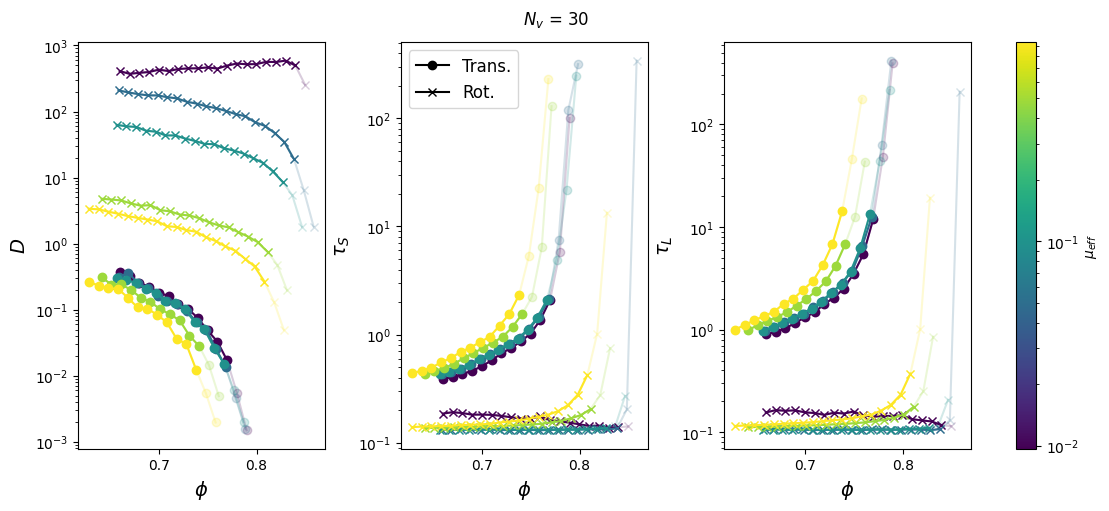

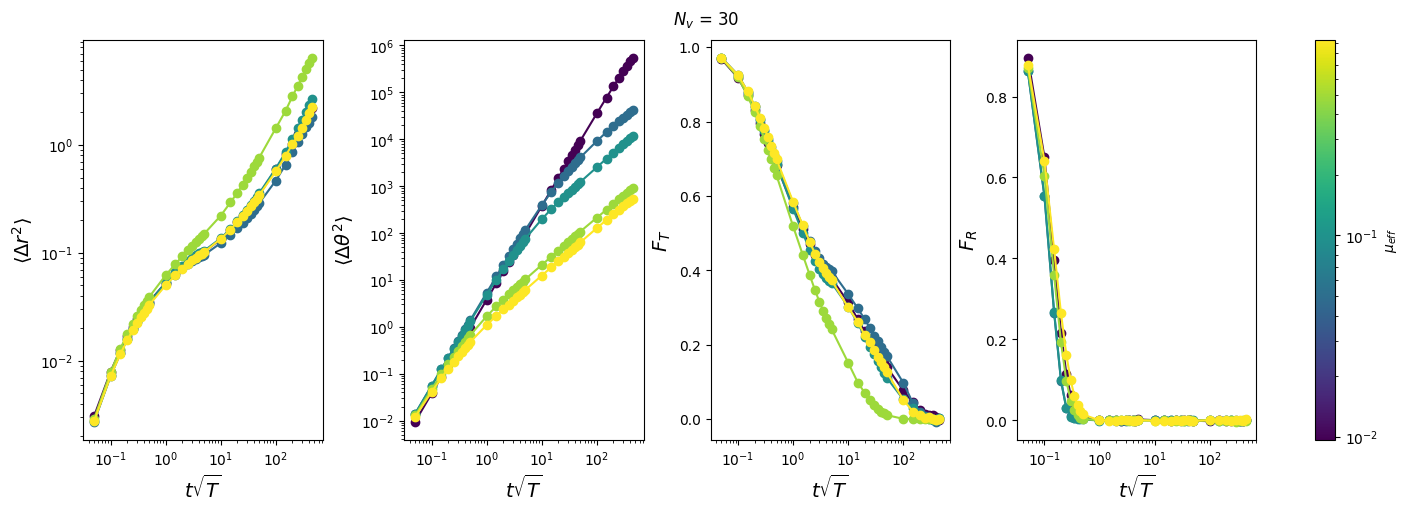

In [7]:
i_plot = -2
subtract_phi_max = False

    # mask = (effective_geom_data.nv == nv)
    # plt.plot(effective_geom_data.mu_eff[mask], effective_geom_data.phi_eff[mask] / effective_geom_data.phi[mask], marker='o', c=cmap(nv_norm(nv)))

translation_run_packages = {
    k: [] for k in system_data.file_mu_route.unique()
}

rotation_run_packages = {
    k: [] for k in system_data.file_mu_route.unique()
}

for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    cmap = plt.get_cmap('viridis')
    mu_eff_norm = LogNorm(vmin=mu_eff_values.min(), vmax=mu_eff_values.max())

    fig, ax = plt.subplots(1, 3, figsize=(11, 5), constrained_layout=True, sharex=True)
    for mu_eff in mu_eff_values:
        mask2 = mask & (system_data.mu_eff == mu_eff)
        i_plot_T = np.where(~np.isnan(system_data.D[mask2]))[0][i_plot]
        i_plot_R = np.where(~np.isnan(system_data.D_R[mask2]))[0][i_plot]

        max_phi = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        for alpha, zorder, T_cut, R_cut in zip([0.2, 1], [0, 10], [-1, i_plot_T], [-1, i_plot_R]):
            x_T = system_data.phi[mask2][:T_cut].copy()
            x_R = system_data.phi[mask2][:R_cut].copy()
            if subtract_phi_max:
                x_T = max_phi - x_T
                x_R = max_phi - x_R
            ax[0].plot(x_T, system_data.D[mask2][:T_cut], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[0].plot(x_R, system_data.D_R[mask2][:R_cut], c=cmap(mu_eff_norm(mu_eff)), marker='x', alpha=alpha, zorder=zorder)

            ax[1].plot(x_T, system_data.tau_small[mask2][:T_cut], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].plot(x_R, system_data.tau_R_small[mask2][:R_cut], c=cmap(mu_eff_norm(mu_eff)), marker='x', alpha=alpha, zorder=zorder)

            ax[2].plot(x_T, system_data.tau_large[mask2][:T_cut], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[2].plot(x_R, system_data.tau_R_large[mask2][:R_cut], c=cmap(mu_eff_norm(mu_eff)), marker='x', alpha=alpha, zorder=zorder)
    for a in ax:
        a.set_yscale('log')
        if subtract_phi_max:
            a.set_xscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$D$', fontsize=14)
    ax[1].set_ylabel(r'$\tau_S$', fontsize=14)
    ax[2].set_ylabel(r'$\tau_L$', fontsize=14)

    ax[1].get_shared_y_axes().joined(ax[1], ax[2])  # join the y-axes of ax[1] and ax[2]

    ax[1].plot([], [], c='k', marker='o', label='Trans.')
    ax[1].plot([], [], c='k', marker='x', label='Rot.')
    ax[1].legend(fontsize=12)

    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/dynamics/{nv-1}.png', dpi=300)
    plt.show()



    fig, ax = plt.subplots(1, 4, figsize=(14, 5), constrained_layout=True, sharex=True)
    for mu_eff in mu_eff_values:
        mask2 = mask & (system_data.mu_eff == mu_eff)

        ids = np.where((time_dependent_data['nv'] == nv) & (time_dependent_data['mu_eff'] == mu_eff))[0]
        trans_relax_ids = ids[~np.isnan(system_data.D[mask2])]
        rot_relax_ids = ids[~np.isnan(system_data.D_R[mask2])]

        mu_route = system_data.file_mu_route.values[trans_relax_ids[i_plot]]
        translation_run_packages[mu_route].append((system_data.file_name.values[trans_relax_ids[i_plot]], nv))
        rotation_run_packages[mu_route].append((system_data.file_name.values[rot_relax_ids[i_plot]], nv))

        m = time_dependent_data['msd'][trans_relax_ids[i_plot]]
        am = time_dependent_data['msad'][trans_relax_ids[i_plot]]
        isf_small = time_dependent_data['isf_small'][trans_relax_ids[i_plot]]
        aisf_small = time_dependent_data['aisf_small'][trans_relax_ids[i_plot]]
        t = time_dependent_data['t'][trans_relax_ids[i_plot]]
        ax[0].plot(t, m, c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[1].plot(t, am, c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[2].plot(t, isf_small, c=cmap(mu_eff_norm(mu_eff)), marker='o')
        ax[3].plot(t, aisf_small, c=cmap(mu_eff_norm(mu_eff)), marker='o')
    for a in ax:
        a.set_xscale('log')
        a.set_xlabel(r'$t \sqrt{T}$', fontsize=14)
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    ax[0].set_ylabel(r'$\langle \Delta r^2 \rangle$', fontsize=14)
    ax[1].set_ylabel(r'$\langle \Delta \theta^2 \rangle$', fontsize=14)
    ax[2].set_ylabel(r'$F_T$', fontsize=14)
    ax[3].set_ylabel(r'$F_R$', fontsize=14)

    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/dynamics-scalars/{nv-1}.png', dpi=300)
    plt.show()


In [8]:
translation_run_packages

{'0.10': [('dynamics_15', np.int32(4)),
  ('dynamics_13', np.int32(7)),
  ('dynamics_12', np.int32(11)),
  ('dynamics_12', np.int32(21)),
  ('dynamics_12', np.int32(31))],
 '0.05': [('dynamics_13', np.int32(4)),
  ('dynamics_12', np.int32(7)),
  ('dynamics_11', np.int32(11)),
  ('dynamics_12', np.int32(21)),
  ('dynamics_12', np.int32(31))],
 '0.50': [('dynamics_25', np.int32(4)),
  ('dynamics_16', np.int32(7)),
  ('dynamics_14', np.int32(11)),
  ('dynamics_12', np.int32(21)),
  ('dynamics_11', np.int32(31))],
 '1.00': [('dynamics_28', np.int32(4)),
  ('dynamics_18', np.int32(7)),
  ('dynamics_14', np.int32(11)),
  ('dynamics_12', np.int32(21)),
  ('dynamics_12', np.int32(31))],
 '0.01': [('dynamics_13', np.int32(4)),
  ('dynamics_12', np.int32(7)),
  ('dynamics_12', np.int32(11)),
  ('dynamics_12', np.int32(21)),
  ('dynamics_12', np.int32(31))]}

In [9]:
rotation_run_packages

{'0.10': [('dynamics_21', np.int32(4)),
  ('dynamics_19', np.int32(7)),
  ('dynamics_19', np.int32(11)),
  ('dynamics_18', np.int32(21)),
  ('dynamics_18', np.int32(31))],
 '0.05': [('dynamics_20', np.int32(4)),
  ('dynamics_19', np.int32(7)),
  ('dynamics_18', np.int32(11)),
  ('dynamics_18', np.int32(21)),
  ('dynamics_19', np.int32(31))],
 '0.50': [('dynamics_28', np.int32(4)),
  ('dynamics_23', np.int32(7)),
  ('dynamics_20', np.int32(11)),
  ('dynamics_19', np.int32(21)),
  ('dynamics_18', np.int32(31))],
 '1.00': [('dynamics_29', np.int32(4)),
  ('dynamics_24', np.int32(7)),
  ('dynamics_21', np.int32(11)),
  ('dynamics_19', np.int32(21)),
  ('dynamics_19', np.int32(31))],
 '0.01': [('dynamics_19', np.int32(4)),
  ('dynamics_18', np.int32(7)),
  ('dynamics_18', np.int32(11)),
  ('dynamics_19', np.int32(21)),
  ('dynamics_19', np.int32(31))]}

# Effective Geometry

This uses the effective packing fraction from the Hsiao papers - where the diameter of the particles is taken as the angular average across the particle surface.  The packing fraction is then determined for that of a system of disks with radii given by the angular average radii.  The errors can be up to a few % in $\phi$.

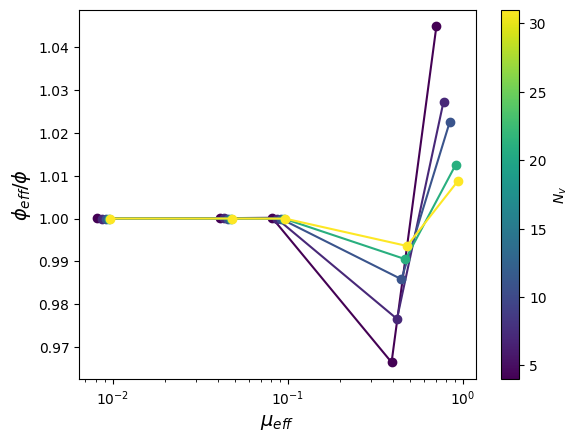

In [10]:
nv_norm = plt.Normalize(vmin=effective_geom_data.nv.min(), vmax=effective_geom_data.nv.max())
for nv in effective_geom_data.nv.unique():
    mask = (effective_geom_data.nv == nv)
    plt.plot(effective_geom_data.mu_eff[mask], effective_geom_data.phi_eff[mask] / effective_geom_data.phi[mask], marker='o', c=cmap(nv_norm(nv)))
plt.xscale('log')
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(effective_geom_data.nv.unique())
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.xlabel(r'$\mu_{eff}$', fontsize=14)
plt.ylabel(r'$\phi_{eff} / \phi$', fontsize=14)
plt.savefig('figures/effective-packing-fraction.png', dpi=600)
plt.show()

# Radial Distribution Function

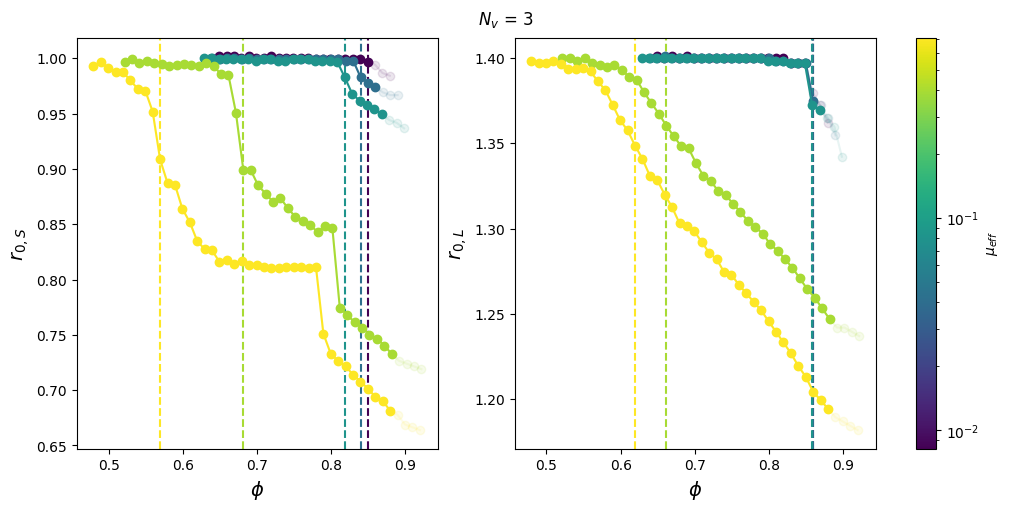

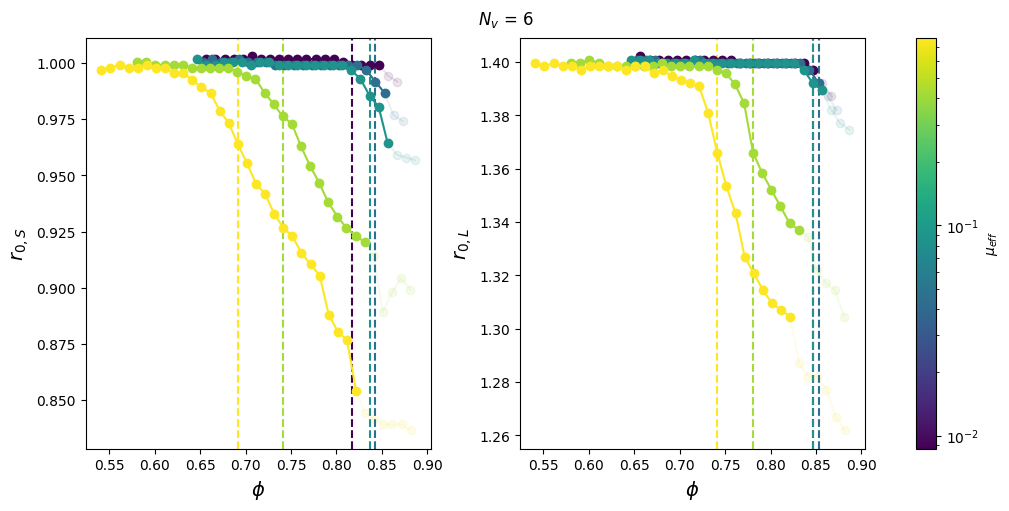

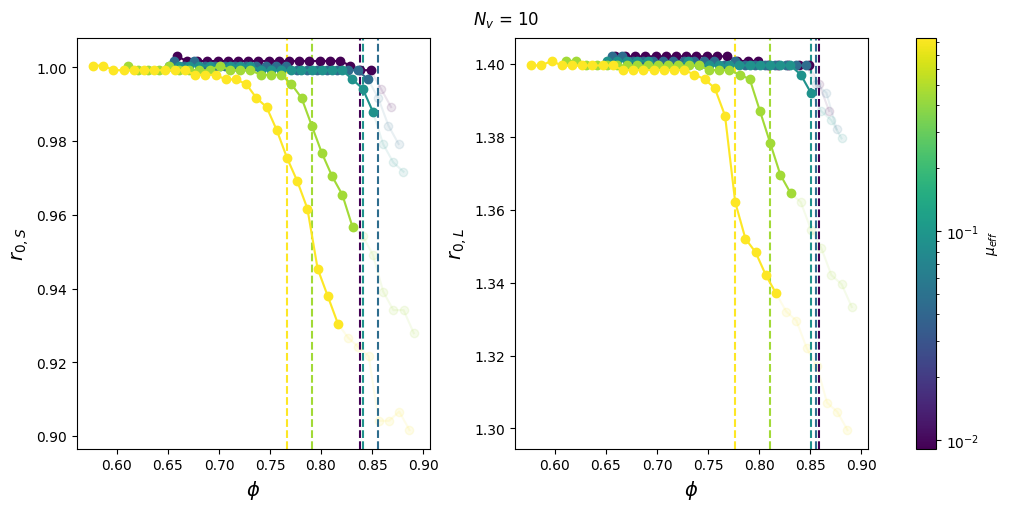

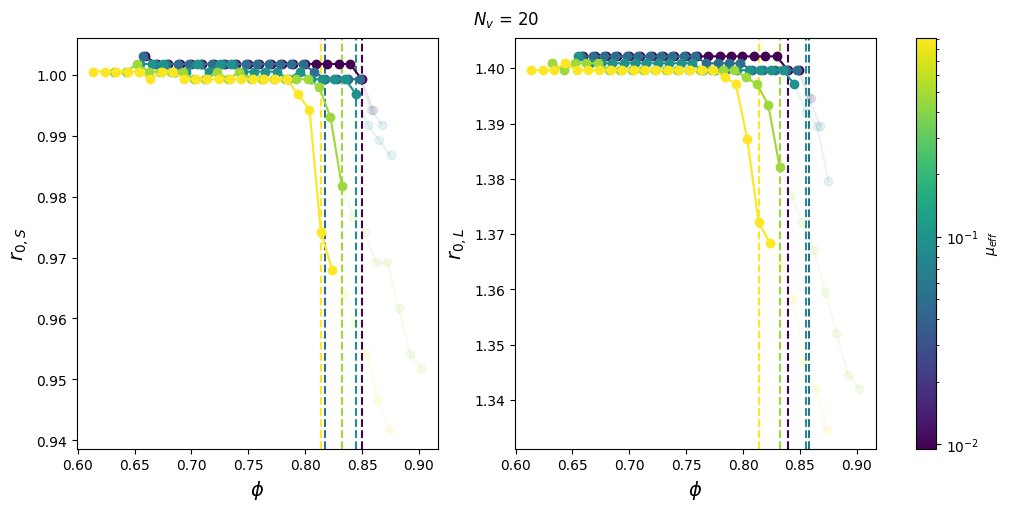

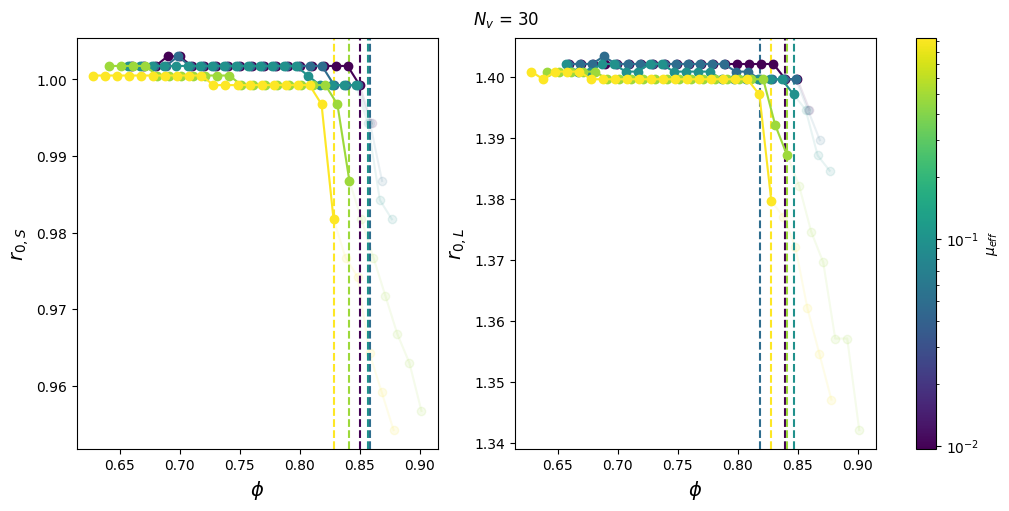

In [11]:
show_phi_b = True
show_phi_eff_j = False
show_outer_phi_eff_j = False

phi_b_data = {
    'mu': [],
    'nv': [],
    'phi_b_small': [],
    'phi_b_large': [],
    'phi_j_eff': [],
    'outer_phi_j_eff': []
}

def find_phi_b(_r, _phi, plateau_length=10, phi_b_cutoff_fraction=0.8):
    r = _r.copy()
    phi = _phi.copy()
    r /= np.mean(r[:plateau_length])
    r -= 1
    r /= np.abs(r[-1])
    r += 1
    return phi[np.where(r < phi_b_cutoff_fraction)[0][0]]

for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    cmap = plt.get_cmap('viridis')
    mu_eff_norm = LogNorm(vmin=mu_eff_values.min(), vmax=mu_eff_values.max())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True, sharex=True)
    for mu_eff in mu_eff_values:
        mask2 = mask & (system_data.mu_eff == mu_eff)

        max_phi = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        mask3 = mask2 & (system_data.phi <= max_phi)


        for zorder, alpha, m in zip([0, 10], [0.1, 1], [mask2, mask3]):
            ax[0].plot(system_data.phi[m], system_data.r0_small[m], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].plot(system_data.phi[m], system_data.r0_large[m], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

        # find phi_b for the small and large particles
        # if nv > 11:
        #     plateau_length = 5
        #     phi_b_cutoff_fraction = 0.5
        # else:
        #     plateau_length = 5
        #     phi_b_cutoff_fraction = 0.99
        plateau_length = 10
        phi_b_cutoff_fraction = 0.8

        phi_b_small = find_phi_b(system_data.r0_small[mask2].values, system_data.phi[mask2].values, plateau_length, phi_b_cutoff_fraction)
        system_data.loc[mask2, 'phi_b_small'] = phi_b_small
        if show_phi_b:
            ax[0].axvline(phi_b_small, c=cmap(mu_eff_norm(mu_eff)), linestyle='--')
        
        phi_b_large = find_phi_b(system_data.r0_large[mask2].values, system_data.phi[mask2].values, plateau_length, phi_b_cutoff_fraction)
        system_data.loc[mask2, 'phi_b_large'] = phi_b_large
        if show_phi_b:
            ax[1].axvline(phi_b_large, c=cmap(mu_eff_norm(mu_eff)), linestyle='--')

        geom_mask = np.isclose(effective_geom_data.mu_eff, mu_eff) & (effective_geom_data.nv == nv)
        phi = system_data.phi[mask2].values
        phi_eff = phi * (effective_geom_data.phi_eff / effective_geom_data.phi)[geom_mask].values
        outer_phi_eff = phi * (effective_geom_data.outer_phi_eff / effective_geom_data.phi)[geom_mask].values
        phi_eff_j = phi[np.argmin(np.abs(phi_eff - 0.84))]
        outer_phi_eff_j = phi[np.argmin(np.abs(outer_phi_eff - 0.84))]
        if show_phi_eff_j:
            for a in ax:
                a.axvline(phi_eff_j, c=cmap(mu_eff_norm(mu_eff)), linestyle=':')
        if show_outer_phi_eff_j:
            for a in ax:
                a.axvline(outer_phi_eff_j, c=cmap(mu_eff_norm(mu_eff)), linestyle='-.')

        phi_b_data['mu'].append(mu_eff)
        phi_b_data['nv'].append(nv)
        phi_b_data['phi_b_small'].append(phi_b_small)
        phi_b_data['phi_b_large'].append(phi_b_large)
        phi_b_data['phi_j_eff'].append(phi_eff_j)
        phi_b_data['outer_phi_j_eff'].append(outer_phi_eff_j)

    for a in ax:
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$r_{0,S}$', fontsize=14)
    ax[1].set_ylabel(r'$r_{0,L}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.savefig(f'figures/gr/{nv-1}.png', dpi=300)
    plt.show()

phi_b_data = pd.DataFrame(phi_b_data)
phi_b_data.to_csv('phi_b_data.csv', index=False)

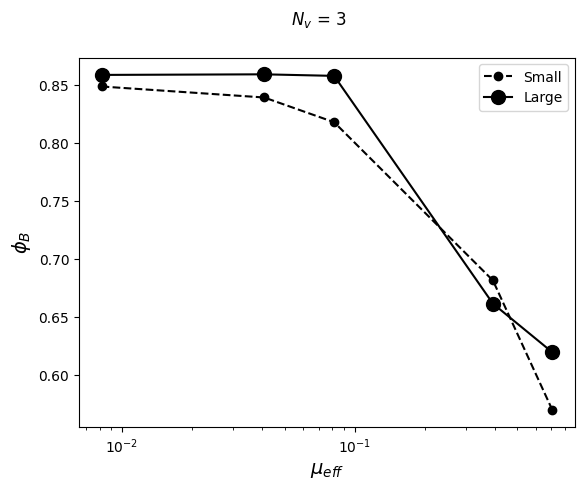

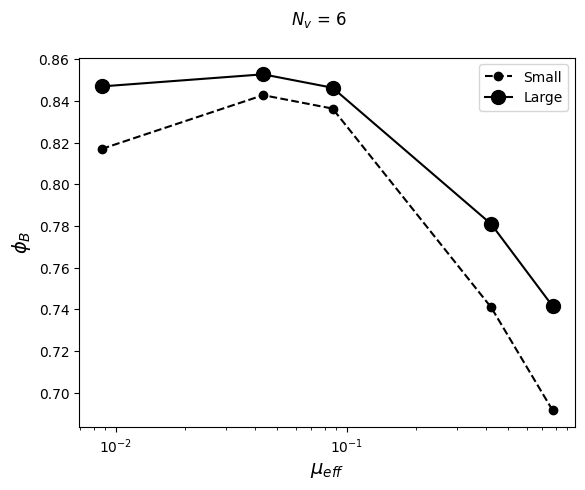

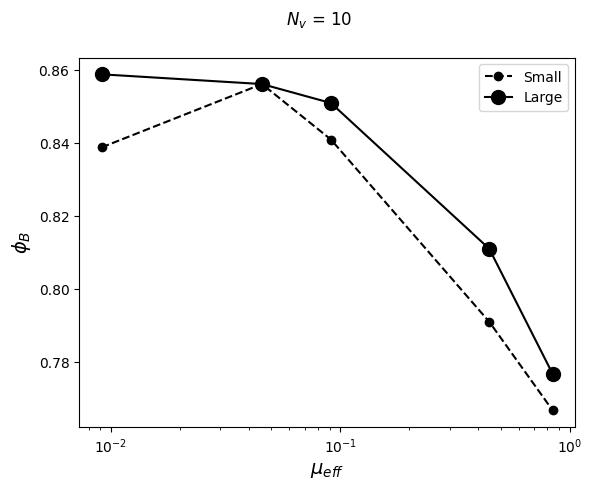

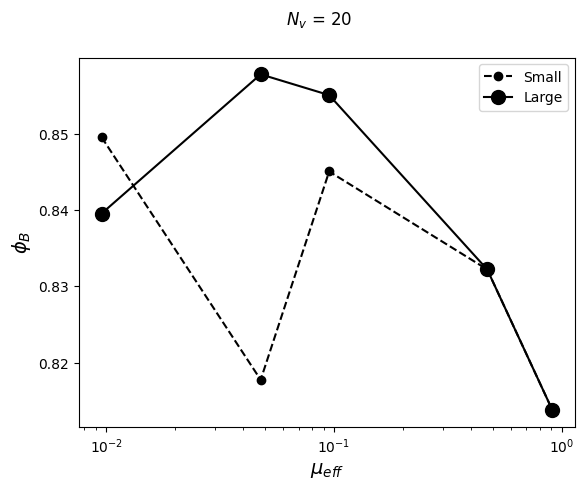

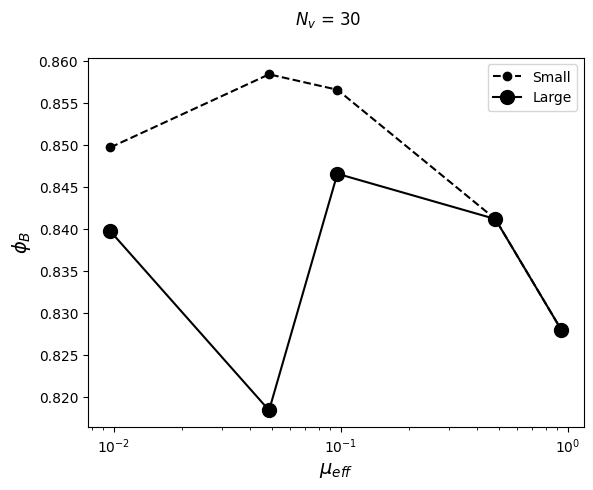

In [12]:
for nv in np.unique(system_data.nv):
    mask = system_data.nv == nv
    mu_eff_values = np.unique(system_data[mask].mu_eff)

    mu_val = system_data.mu_eff[mask].values
    phi_b_small_val = system_data.phi_b_small[mask].values
    phi_b_large_val = system_data.phi_b_large[mask].values
    order = np.argsort(mu_val)
    mu_val = mu_val[order]
    phi_b_small_val = phi_b_small_val[order]
    phi_b_large_val = phi_b_large_val[order]

    mu_val_unique, ids = np.unique(mu_val, return_index=True)
    phi_b_small_val = phi_b_small_val[ids]
    phi_b_large_val = phi_b_large_val[ids]
    mu_val = mu_val_unique

    plt.plot(mu_val, phi_b_small_val, c='k', marker='o', label='Small', linestyle='--')
    plt.plot(mu_val, phi_b_large_val, c='k', marker='o', label='Large', ms=10)
    plt.xscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    plt.legend()
    plt.xlabel(r'$\mu_{eff}$', fontsize=14)
    plt.ylabel(r'$\phi_B$', fontsize=14)
    plt.savefig(f'figures/phi_b/{nv-1}.png', dpi=300)
    plt.show()


In [38]:
phi_j_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/analyzing-data-from-cluster/jamming/phi_j_data.csv')
phi_j_range_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/phi_j_range_data.csv')
trans_phi_c_data = pd.read_csv('/Users/marshallmccraw/Projects/yale/analysis/fall-25/10/resumed-dynamics-runs/trans_phi_c_data.csv')

In [ ]:
for nv in phi_b_data.nv.unique():
    mask = phi_b_data.nv == nv
    plt.plot(phi_b_data.mu[mask], phi_b_data.phi_b_small[mask], marker='o', color=cmap(nv_norm(nv)))
    # plt.plot(phi_b_data.mu[mask], phi_b_data.phi_b_large[mask], marker='o', markersize=10)
    # plt.plot(phi_b_data.mu[mask], phi_b_data.phi_j_eff[mask], marker='s')
    # plt.plot(phi_b_data.mu[mask], phi_b_data.outer_phi_j_eff[mask])

    mask2 = trans_phi_c_data.nv == nv
    plt.plot(trans_phi_c_data.mu[mask2], trans_phi_c_data.phi_c_tau_T[mask], color=cmap(nv_norm(nv)), alpha=0.5, zorder=0, marker='s', linestyle='--')
plt.plot([], [], marker='s', linestyle='--', alpha=0.5, color='k', label=r'$\phi_{c,T}$')
plt.legend(fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\mu_{eff}$', fontsize=14)
plt.ylabel(r'$\phi_B$', fontsize=14)
sm = plt.cm.ScalarMappable(norm=nv_norm, cmap=cmap)
sm.set_array(phi_b_data.nv.values)
cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$N_v$')
plt.savefig(f'figures/phi_b.png', dpi=600)
plt.show()

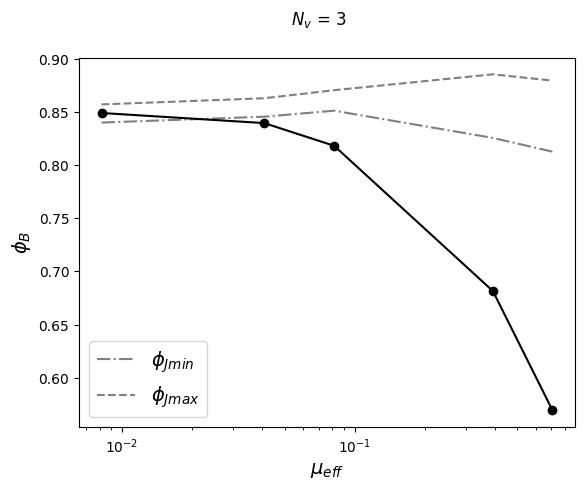

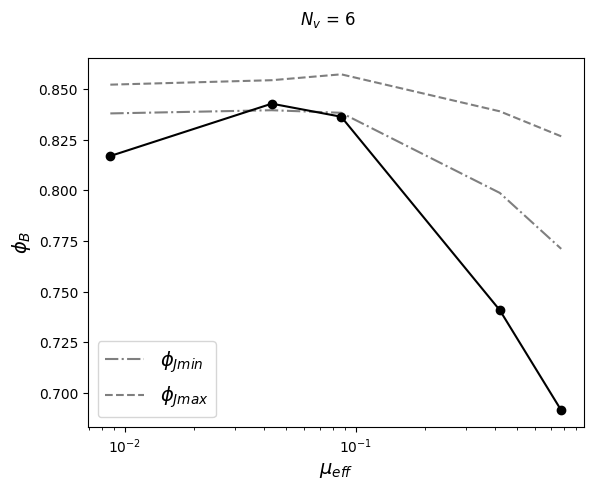

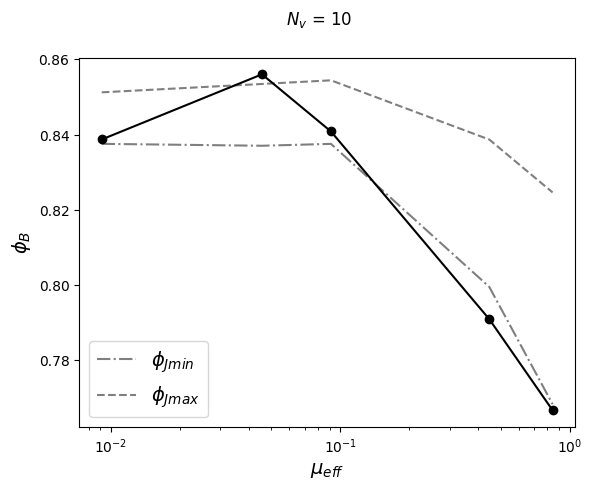

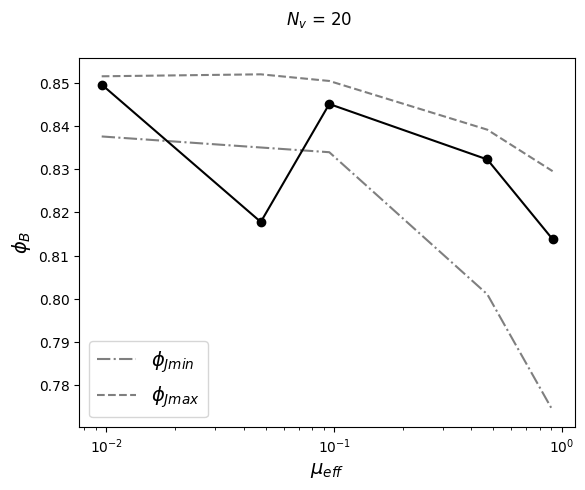

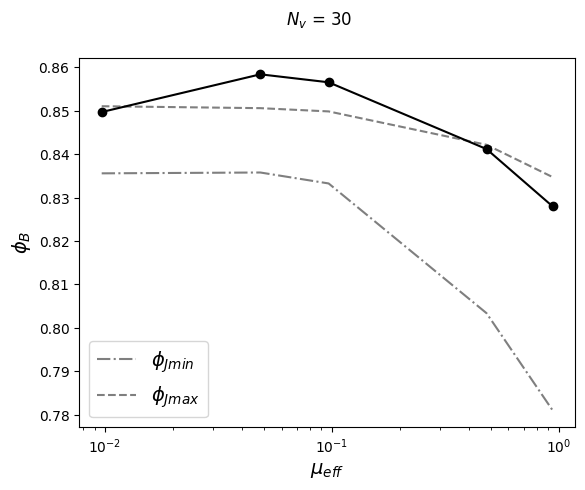

In [29]:
for nv in phi_b_data.nv.unique():
    mask = phi_b_data.nv == nv
    plt.plot(phi_b_data.mu[mask], phi_b_data.phi_b_small[mask], marker='o', color='k')
    # plt.plot(phi_b_data.mu[mask], phi_b_data.phi_b_large[mask], marker='o', markersize=10)
    # plt.plot(phi_b_data.mu[mask], phi_b_data.phi_j_eff[mask], marker='s')
    # plt.plot(phi_b_data.mu[mask], phi_b_data.outer_phi_j_eff[mask])
    phi_j_mask = phi_j_range_data.nv == nv
    plt.plot(phi_j_range_data[phi_j_mask].mu, phi_j_range_data[phi_j_mask].phi_j_min, color='k', alpha=0.5, zorder=0, linestyle='-.', label=r'$\phi_{J min}$')
    plt.plot(phi_j_range_data[phi_j_mask].mu, phi_j_range_data[phi_j_mask].phi_j_max, color='k', alpha=0.5, zorder=0, linestyle='--', label=r'$\phi_{J max}$')
    plt.legend(fontsize=14)
    plt.xscale('log')
    plt.xlabel(r'$\mu_{eff}$', fontsize=14)
    plt.ylabel(r'$\phi_B$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    plt.savefig(f'figures/phi_b_and_jamming/NV-{nv}.png', dpi=600)
    plt.show()

# Pressure Data

In [24]:
pressure_data = {
    'phi': [],
    'nv': [],
    'mu_eff': [],
    'pressure': [],
    'mean_off_diag': [],
    # 't': [],
    # 'vacf': [],
    # 'angular_vacf': [],
}

for friction_coefficient in os.listdir(dirname)[::-1]:
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        pressure_path = os.path.join(friction_dir, f'pressure_{file_index}')
        if not os.path.exists(os.path.join(pressure_path, 'meta.h5')):
            continue
        data = dp.data.load(pressure_path, location=['final', 'init'])
        if len(data.final.arrays.keys()) == 0:
            continue
        data.calculate_mu_eff()

        vacf = data.final.vacf
        angular_vacf = data.final.angular_vacf
        t = data.final.t
        mean_off_diag = data.final.mean_off_diag
        mean_pressure = data.final.mean_pressure

        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu_eff = data.mu_eff[data.system_offset[:-1]]
        phi = data.packing_fraction

        pressure_data['phi'].extend(phi)
        pressure_data['nv'].extend(nv)
        pressure_data['mu_eff'].extend(mu_eff)
        pressure_data['pressure'].extend(mean_pressure)
        pressure_data['mean_off_diag'].extend(mean_off_diag)
        # new_data['t'].append(t)
        # new_data['vacf'].append(vacf)
        # new_data['angular_vacf'].append(angular_vacf)

pressure_data = pd.DataFrame(pressure_data)

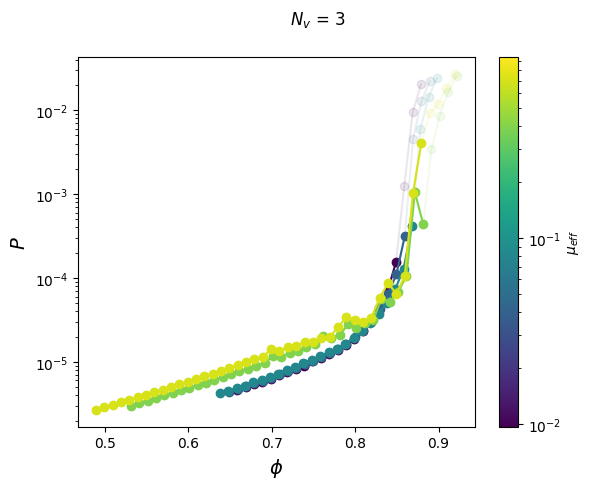

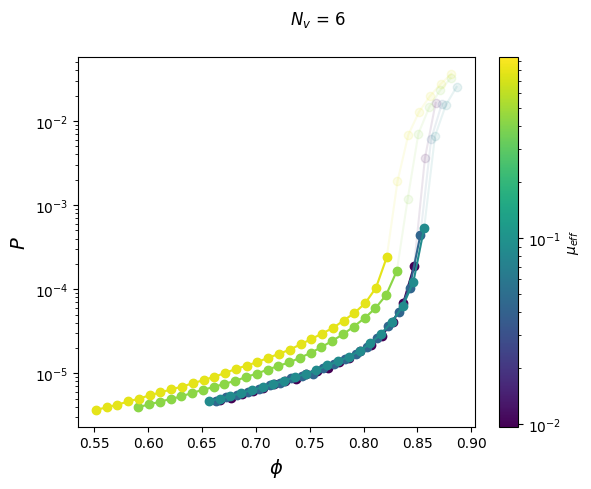

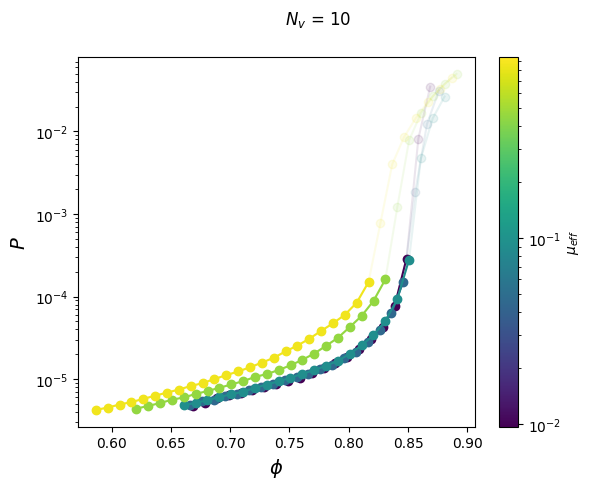

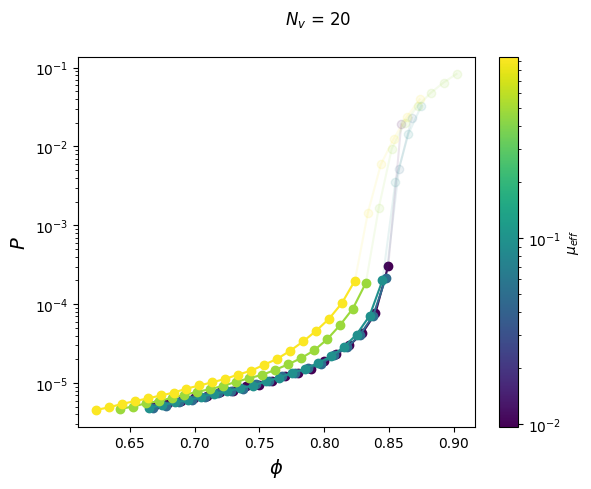

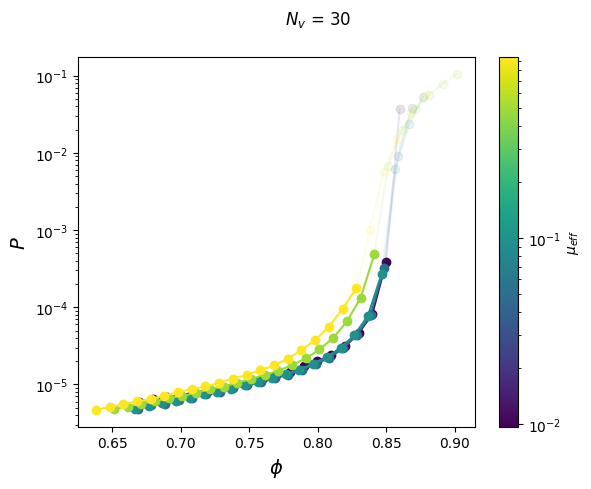

In [28]:
how_scale = 'none'

if how_scale not in ['eff', 'outer_eff', 'none']:
    raise ValueError(f'how_scale: {how_scale} not defined!')

for nv in np.unique(pressure_data.nv):
    mask = pressure_data.nv == nv
    for mu_eff in np.unique(pressure_data.mu_eff[mask]):
        mask2 = mask & (pressure_data.mu_eff == mu_eff)

        max_phi = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]
        mask3 = mask2 & (pressure_data.phi <= max_phi)

        geom_mask = np.isclose(effective_geom_data.nv, nv) & np.isclose(effective_geom_data.mu_eff, mu_eff)
        if how_scale == 'eff':
            scale = (effective_geom_data[geom_mask].phi_eff / effective_geom_data[geom_mask].phi).values[0]
        elif how_scale == 'outer_eff':
            scale = (effective_geom_data[geom_mask].outer_phi_eff / effective_geom_data[geom_mask].phi).values[0]
        else:
            scale = 1
        phi *= scale

        plt.plot(pressure_data.phi[mask3] * scale, pressure_data.pressure[mask3].abs(), c=cmap(mu_eff_norm(mu_eff)), marker='o')

        
        plt.plot(pressure_data.phi[mask2] * scale, pressure_data.pressure[mask2].abs(), c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=0.1)
    
    if how_scale == 'eff':
        phi_label = r'$\phi_{eff}$'
    elif how_scale == 'outer_eff':
        phi_label = r'$\phi_{eff-Disk}$'
    else:
        phi_label = r'$\phi$'
    
    for a in ax:
        plt.yscale('log')
        plt.xlabel(phi_label, fontsize=14)
    plt.ylabel(r'$P$', fontsize=14)

    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.savefig(f'figures/pressure/{nv-1}-scale-{how_scale}.png', dpi=300)
    plt.show()

# Shear Modulus

In [16]:
shear_modulus_data = {
    'phi': [],
    'nv': [],
    'mu_eff': [],
    't': [],
    'shear_modulus': [],
}

for friction_coefficient in os.listdir(dirname)[::-1]:
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        pressure_path = os.path.join(friction_dir, f'shear_modulus_{file_index}')
        if not os.path.exists(os.path.join(pressure_path, 'meta.h5')):
            continue
        data = dp.data.load(pressure_path, location=['final', 'init'])
        if len(data.final.arrays.keys()) == 0:
            continue
        data.calculate_mu_eff()

        t = data.final.t * dt * np.sqrt(T)
        shear_modulus = data.final.shear_modulus

        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu_eff = data.mu_eff[data.system_offset[:-1]]
        phi = data.packing_fraction

        shear_modulus_data['phi'].append(phi)
        shear_modulus_data['nv'].append(nv)
        shear_modulus_data['mu_eff'].append(mu_eff)
        shear_modulus_data['t'].append(np.column_stack([t for _ in range(shear_modulus.shape[1])]).T)
        shear_modulus_data['shear_modulus'].append(shear_modulus.T)

shear_modulus_data = {k: np.concatenate(v) for k, v in shear_modulus_data.items()}

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/3449486476.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(phis[m], G0s[m], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/3449486476.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(phis[m], taus[m], c=cmap(mu_eff_norm(mu_eff)), marker='o

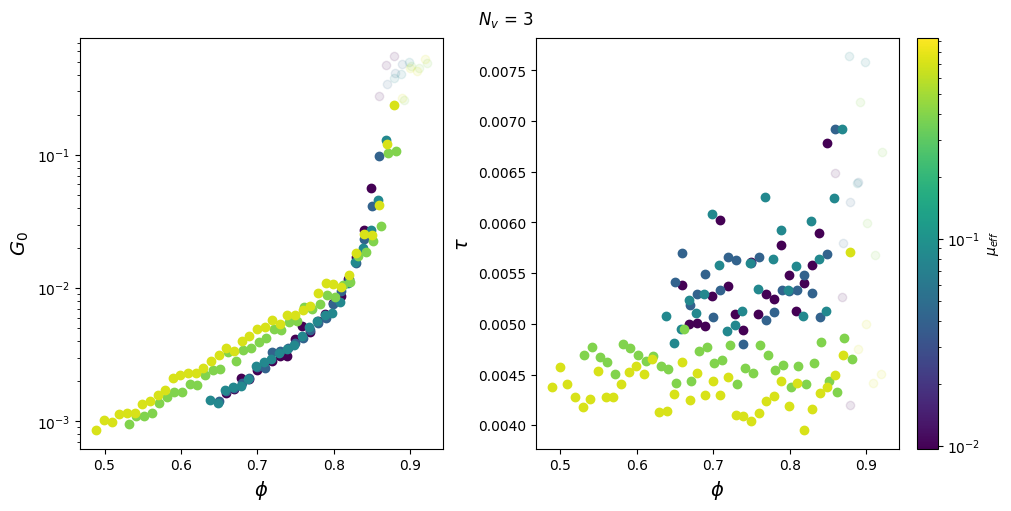

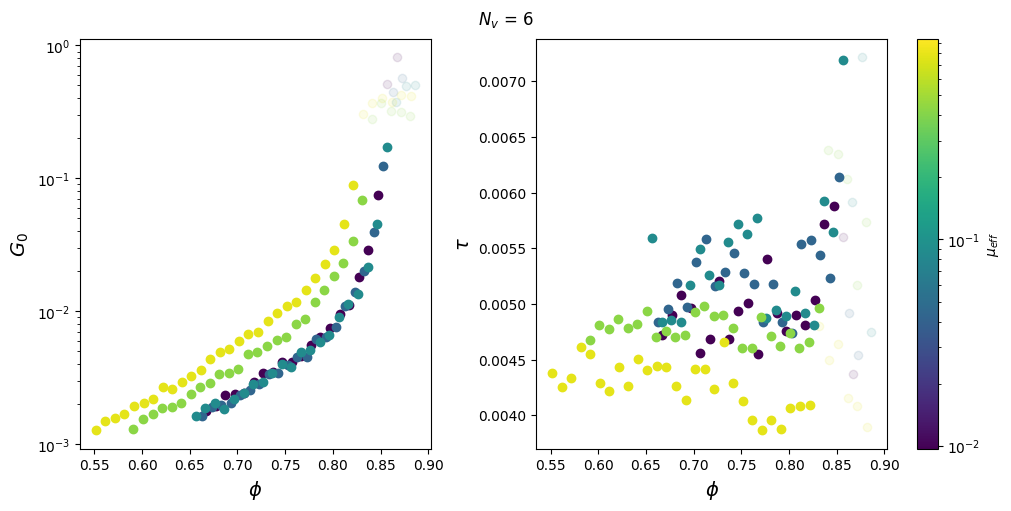

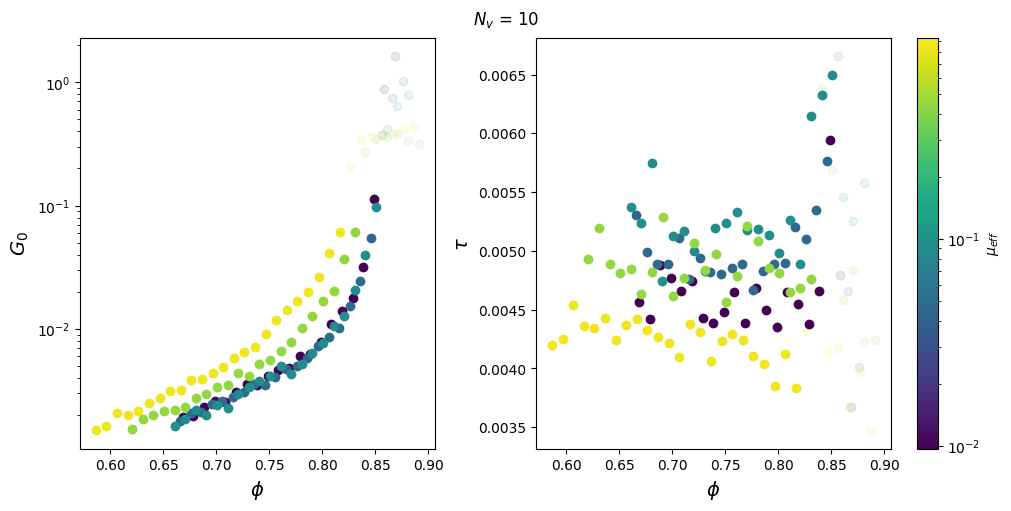

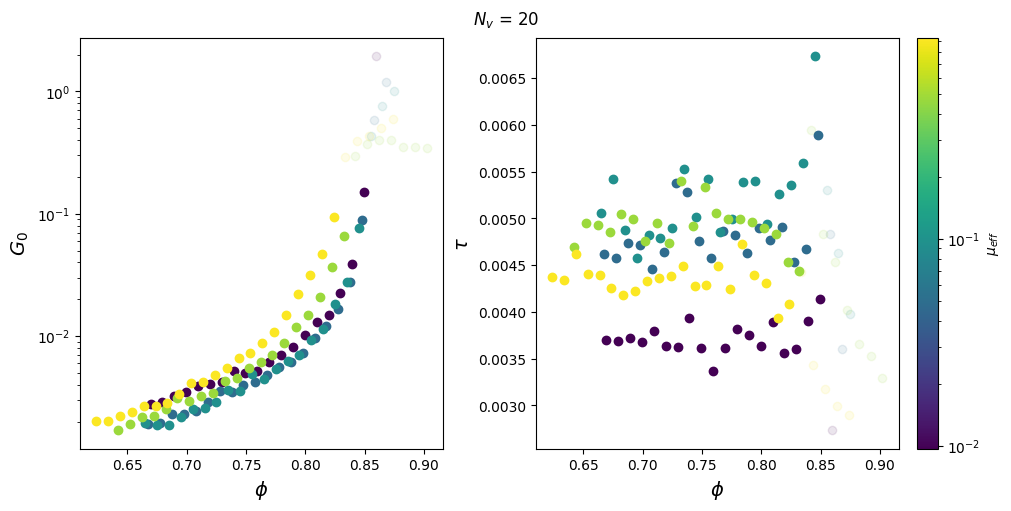

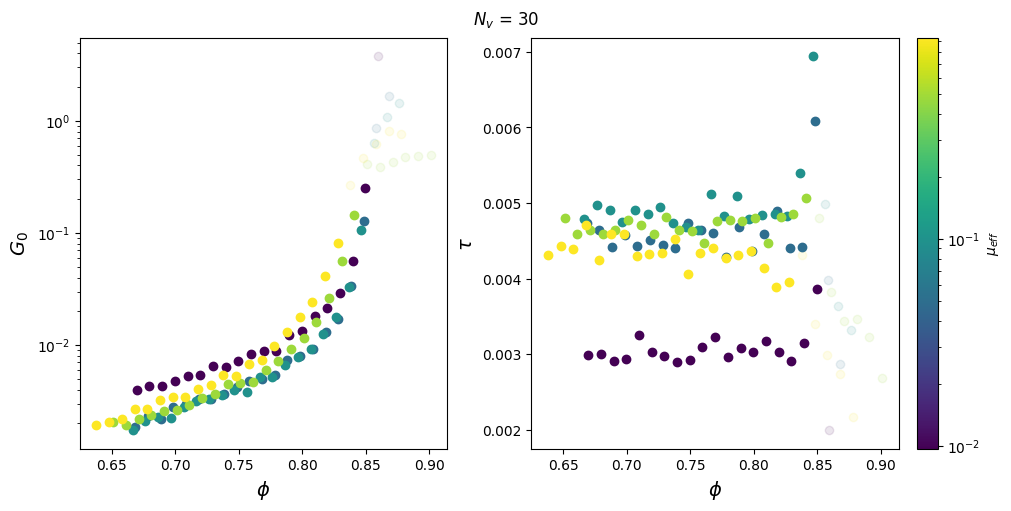

In [17]:
for nv in np.unique(shear_modulus_data['nv']):
    mask = shear_modulus_data['nv'] == nv
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)
    for mu_eff in np.unique(shear_modulus_data['mu_eff'][mask]):
        mask2 = mask & (shear_modulus_data['mu_eff'] == mu_eff)
        taus = []
        G0s = []
        for G, t in zip(shear_modulus_data['shear_modulus'][mask2], shear_modulus_data['t'][mask2]):
            taus.append(get_relaxation_time(G / G[0], t))
            G0s.append(G[0])
        taus = np.array(taus)
        phis = np.unique(shear_modulus_data['phi'][mask2])
        G0s = np.array(G0s)

        max_phi = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]
        mask3 = (shear_modulus_data['phi'][mask2] <= max_phi)

        for i, (zorder, alpha) in enumerate(zip([10, 0], [1, 0.1])):
            if i == 0:
                m = mask3
            else:
                m = np.ones_like(phis, dtype=bool)
            ax[0].scatter(phis[m], G0s[m], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].scatter(phis[m], taus[m], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
    
    for a in ax:
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$G_0$', fontsize=14)
    ax[1].set_ylabel(r'$\tau$', fontsize=14)
    
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')

    plt.show()



# Contacts, Friction, Torques, and Forces

In [18]:
import pickle

contacts_data = {
    'phi': [],
    'nv': [],
    'mu_eff': [],
    'friction_contacts_torques': [],
    'n_contacts_total': [],
    'n_contacts_total_std': [],
    'n_particles': [],
}

for friction_coefficient in os.listdir(dirname)[::-1]:
    friction_dir = os.path.join(dirname, friction_coefficient)
    file_index = 0
    while os.path.exists(run_path := os.path.join(friction_dir, f'dynamics_{file_index}')):
        file_index += 1
        contacts_path = os.path.join(friction_dir, f'contacts_{file_index}')
        if not os.path.exists(os.path.join(contacts_path, 'meta.h5')):
            continue
        data = dp.data.load(contacts_path, location=['final', 'init'])
        if len(data.final.arrays.keys()) == 0:
            continue
        data.calculate_mu_eff()

        nv = data.n_vertices_per_particle[data.system_offset[:-1]]
        mu_eff = data.mu_eff[data.system_offset[:-1]]
        phi = data.packing_fraction

        if not os.path.exists(os.path.join(contacts_path, 'friction_contacts_torques.pkl')):
            print(f'No friction_contacts_torques.pkl for {contacts_path}')
            continue
        with open(os.path.join(contacts_path, 'friction_contacts_torques.pkl'), 'rb') as f:
            friction_contacts_torques = pickle.load(f)
        
        contacts_data['phi'].append(phi)
        contacts_data['nv'].append(nv)
        contacts_data['mu_eff'].append(mu_eff)
        contacts_data['friction_contacts_torques'].append(friction_contacts_torques)
        contacts_data['n_contacts_total'].append(data.n_contacts_total)
        contacts_data['n_contacts_total_std'].append(data.n_contacts_total_std)
        contacts_data['n_particles'].append(data.system_size)

nv_as_array = np.concatenate(contacts_data['nv'])
mu_as_array = np.concatenate(contacts_data['mu_eff'])
phi_as_array = np.concatenate(contacts_data['phi'])

## Contact Types

Two things to look out for here: relative weights of contact types changing with $\phi$ and contacts as a signature of excess overlaps.

First:

The dominant contact type is the 1-1 (1 vertex from one particle touching 1 vertex of another particle).  Approaching jamming, we expectedly see the 1-1 becoming less prevalent and the other higher friction contact types dominating.  Straightforward.

Second:

Due to the circular geometry we are using here, it is not possible (for the most part) to have more than a 2-2 contact.  I say for the most part because there are exceptions for cases such as $N_v=3$ where the contacts can be more intricate.  Aside from this, if we have anything more than a 2-2, this is a result of excess overlaps.  The cases we have to be most mindful of regarding excess overlaps are the large $\mu_{eff}$, large $N_v$ cases when $\sigma_v/\sigma$ is very small.  It is very relieving to see that we seem to not have any such contacts in these cases.  Great!

However, we should note that there are many of these 'bad' contact types for the low friction cases.  This is initially counterintuitive, but it makes sense upon further examination.  In these cases, the vertices within each particle are so overlapped (i.e. all 30 vertices may be overlapping), leaving only tiny regions of exposed area occupied by a single vertex.  Even if our particle overlaps are tiny, we innevitably run into multiple overlaps in these cases.  Thus, we see a significant number of these 'bad' contact types in the purple low $\mu_{eff}$ markers.

This also connects to later results, regarding the magnitude of the interaction force $|F|$.  Here, we find in the $N_v>20$ low $\mu_{eff}$ cases, we have about 3x larger interaction forces.  In the future, I think it would be most appropriate to just scale the resulting interaction strengths in these cases.

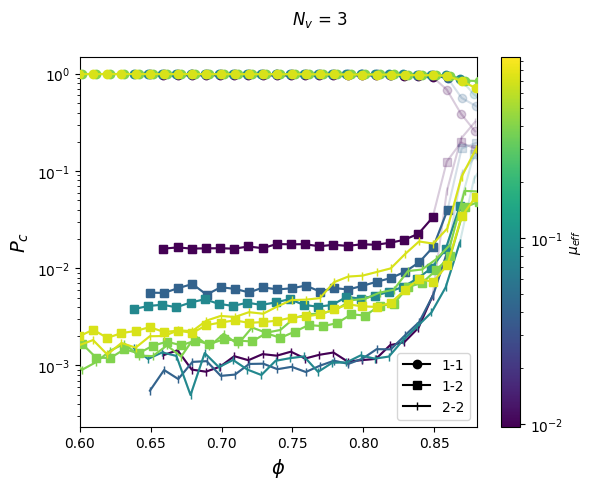

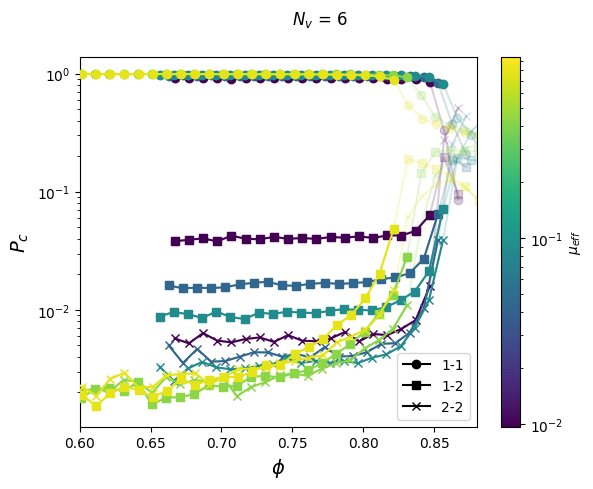

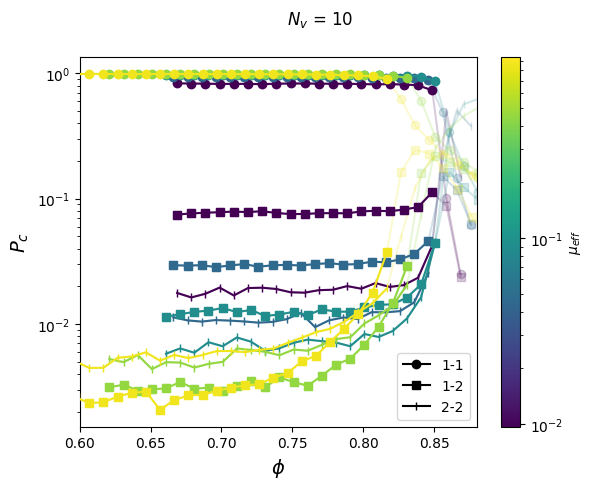

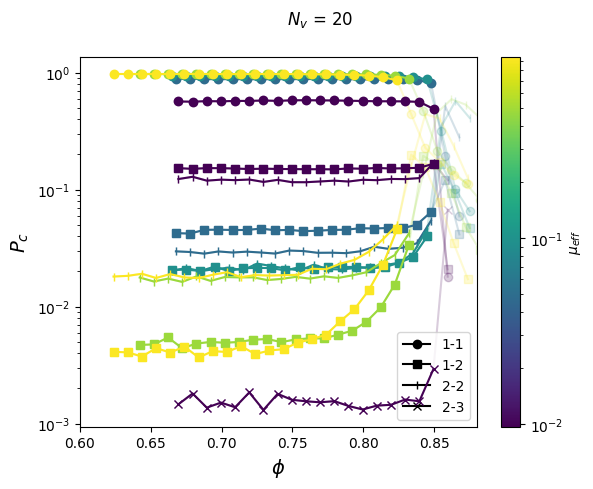

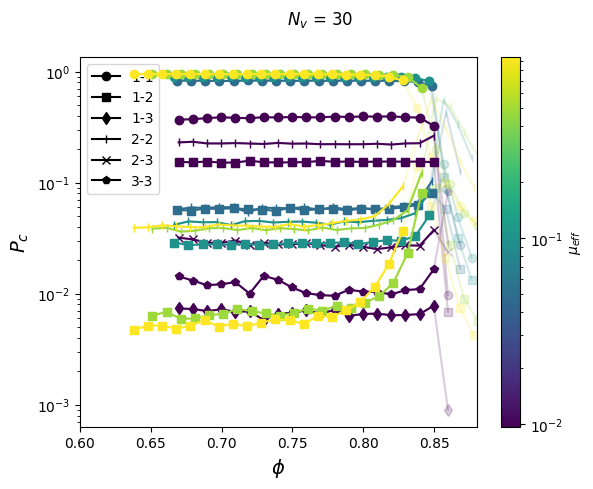

In [76]:
marker_styles = ['o', 's', 'd', '|', 'x', '>', 'D', 'p', '*', 'h', 'H', 'd', '_', 'd', '|', '_']

for nv in np.unique(nv_as_array):
    X, Y = [], []
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        pair_type_count_global = {}

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)
            pair_type_count_hist = contacts_data['friction_contacts_torques'][i]['pair_type_count_hist'][j]
            
            for pair_type in pair_type_count_hist.keys():
                if pair_type not in pair_type_count_global:
                    arr_length = len(phi_global) - 1
                    pair_type_count_global[pair_type] = [0] * arr_length
            
            for pair_type in pair_type_count_global.keys():
                if pair_type in pair_type_count_hist:
                    pair_type_count_global[pair_type].append(pair_type_count_hist[pair_type])
                else:
                    pair_type_count_global[pair_type].append(0)
        
        X.append(np.array(phi_global))
        Y.append({k: np.array(v) for k, v in pair_type_count_global.items()})

    unique_pair_types = np.unique(np.concatenate([list(y.keys()) for y in Y]), axis=0)
    used_markers = {tuple(p): None for p in unique_pair_types}

    for mu_eff, phi, y in zip(np.unique(mu_as_array[nv_as_array == nv]), X, Y):
        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]
        for pair_id, pair_type in enumerate(unique_pair_types):
            k = tuple(pair_type)
            if k not in y:
                continue
            pair_freq = y[k]
            valid_mask = phi <= phi_max
            if np.sum(pair_freq[valid_mask]) <= 1e-2:  # exclude if the pair type is only relevant beyond hard particle regime
                continue
            for mask, zorder, alpha in zip([valid_mask, np.ones_like(phi, dtype=bool)], [10, 0], [1, 0.2]):
                plt.plot(phi[mask], pair_freq[mask], marker=marker_styles[pair_id], c=cmap(mu_eff_norm(mu_eff)), alpha=alpha, zorder=zorder)
            if not used_markers[k]:
                used_markers[k] = marker_styles[pair_id]

        # plt.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_b_small.values[0], c=cmap(mu_eff_norm(mu_eff)))
        # plt.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_j_eff.values[0])
        # plt.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].outer_phi_j_eff.values[0])

    for unique_pair, marker in used_markers.items():
        if marker:
            plt.plot([], [], c='k', marker=marker, label=f'{unique_pair[0]}-{unique_pair[1]}')
    plt.legend()
    plt.yscale('log')
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.ylabel(r'$P_c$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.xlim(0.6, 0.88)
    plt.savefig(f'figures/contacts/NV-{nv}.png', dpi=600)
    plt.show()

## Apparent Friction

We find that the __apparent__ friction felt by the particles (not the theoretical friction coefficient $\mu_{eff}$) depends on $\phi$ with larger $\phi$ leading to increased friction when $\mu_{eff}$ is large.  Although this is entirely unsurprising and completely expected, this __may__ be a consequential result.

# TODO: connect this to range of $\phi_J$ and $\phi_B$

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/1451716990.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(phi_global[mask], mean_friction_coeff_global[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/1451716990.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(phi_global[mask], mea

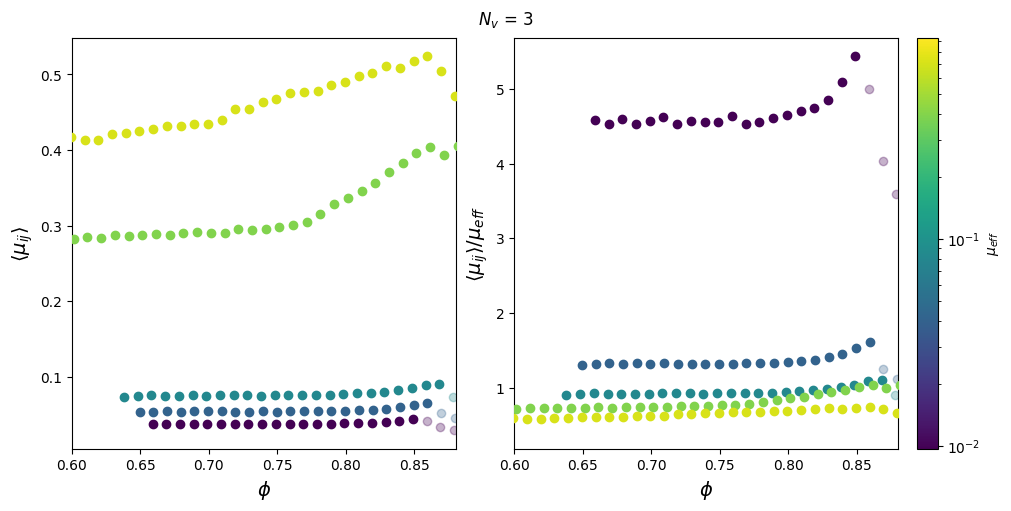

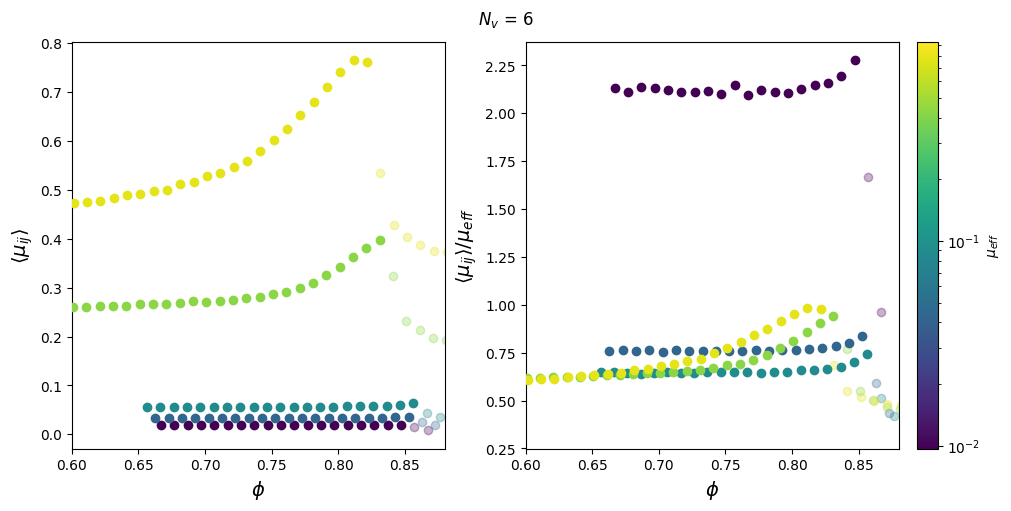

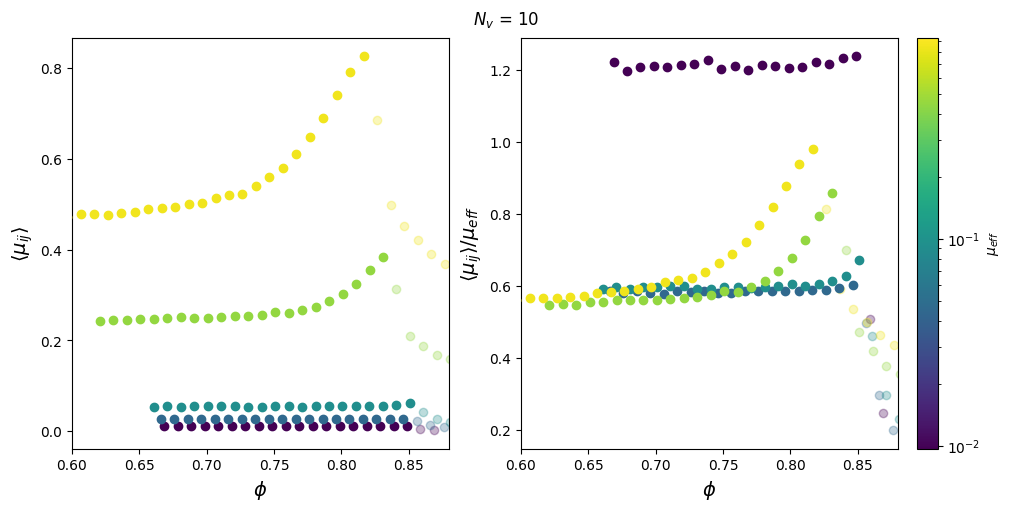

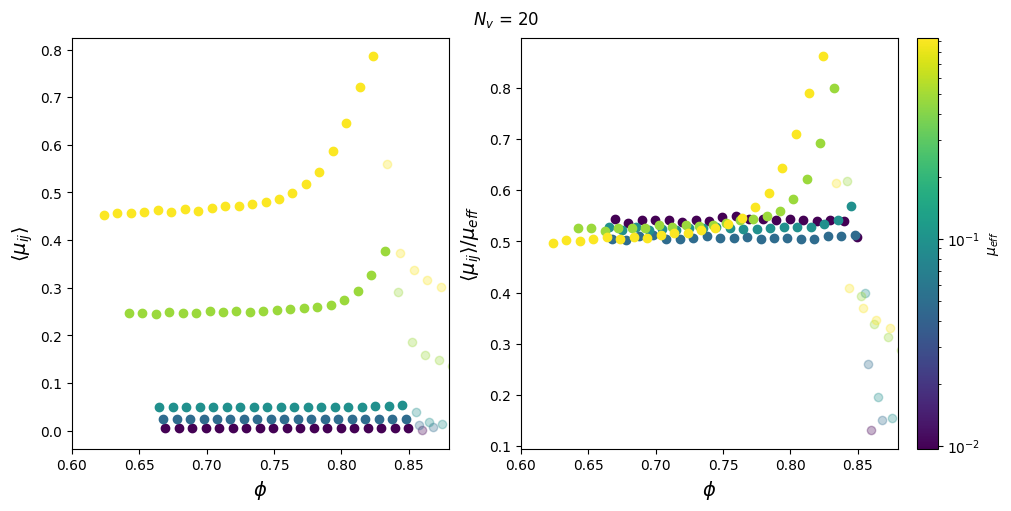

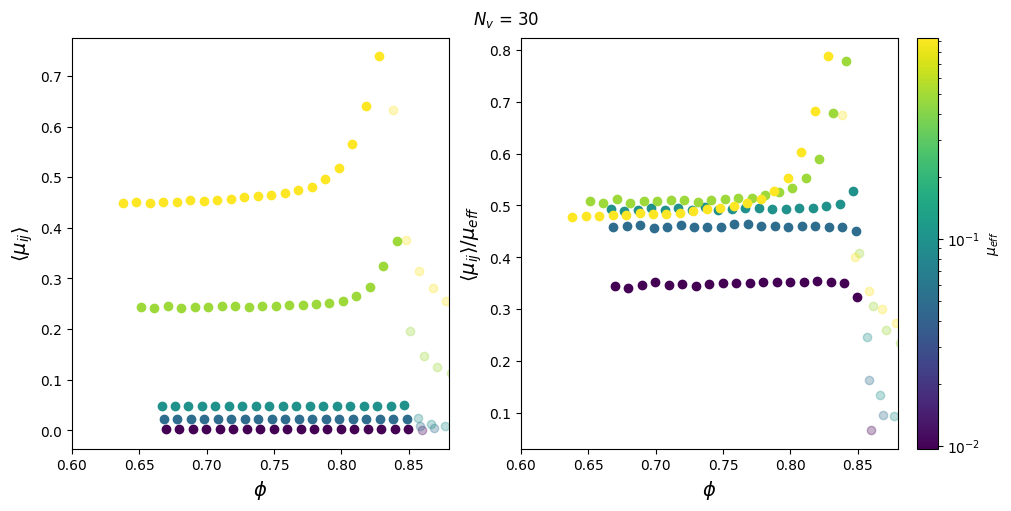

In [91]:
for nv in np.unique(nv_as_array):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)
    
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        mean_friction_coeff_global = []

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)
            friction_coeff_hist = contacts_data['friction_contacts_torques'][i]['friction_coeff_hist'][j]
            mean_friction_coeff_global.append(np.mean(friction_coeff_hist))

        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        phi_global = np.array(phi_global)
        mean_friction_coeff_global = np.array(mean_friction_coeff_global)

        valid_mask = (phi_global <= phi_max)
        for mask, alpha, zorder in zip([valid_mask, ~valid_mask], [1, 0.3], [10, 0]):
            ax[0].scatter(phi_global[mask], mean_friction_coeff_global[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].scatter(phi_global[mask], mean_friction_coeff_global[mask] / mu_eff, c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

        # for a in ax:
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_b_small.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_j_eff.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].outer_phi_j_eff.values[0])

    for a in ax:
        a.set_xlim(0.6, 0.88)
        a.set_xlabel(r'$\phi$', fontsize=14)
        # a.set_yscale('log')
    ax[0].set_ylabel(r'$\langle \mu_{ij} \rangle$', fontsize=14)
    ax[1].set_ylabel(r'$\langle \mu_{ij} \rangle / \mu_{eff}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/friction/NV-{nv}.png', dpi=600)
    plt.show()

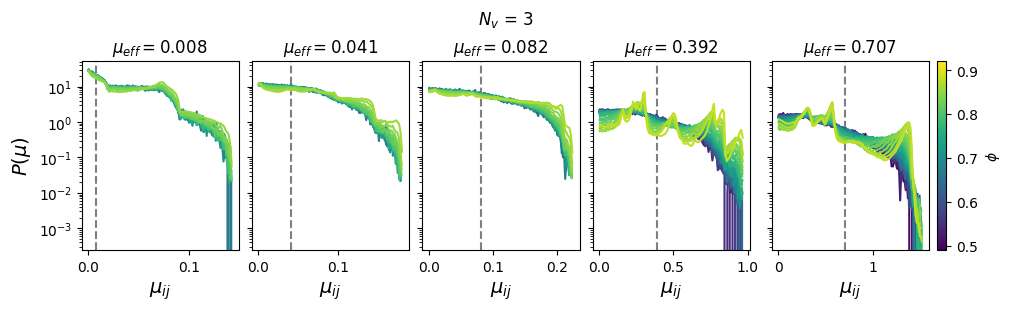

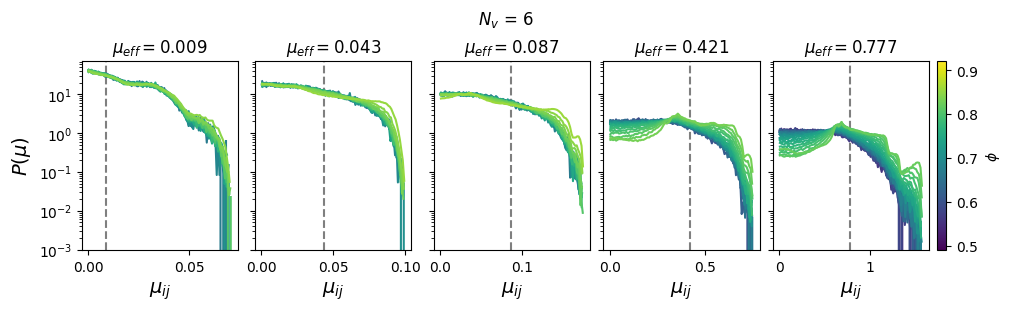

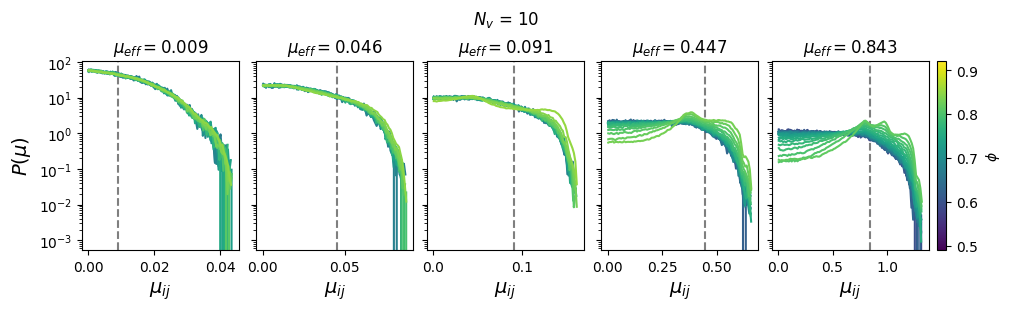

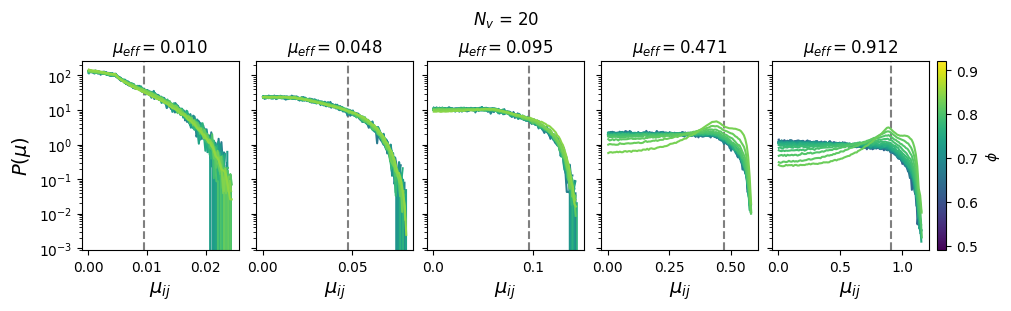

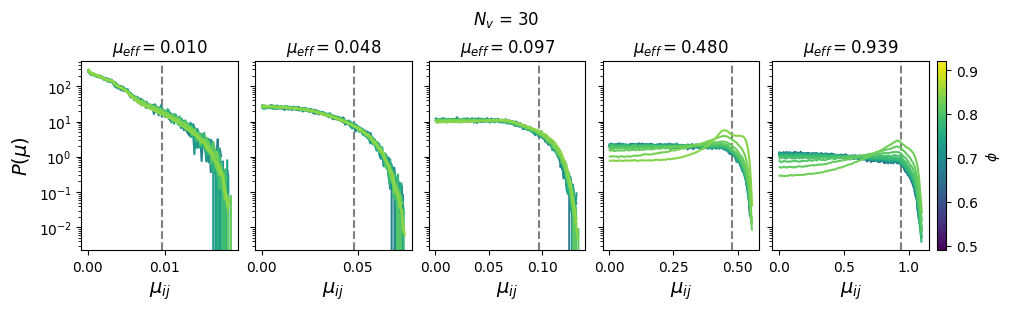

In [92]:
sharex = False
phi_norm = plt.Normalize(vmin=min(phi_as_array), vmax=max(phi_as_array))
for nv in np.unique(nv_as_array):
    fig, ax = plt.subplots(1, np.unique(mu_as_array[nv_as_array == nv]).size, figsize=(10, 3), constrained_layout=True, sharex=sharex, sharey=True)
    for mu_j, mu_eff in enumerate(np.unique(mu_as_array[nv_as_array == nv])):
        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]
        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            phi_i = contacts_data['phi'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            if phi_i[j] > phi_max:
                continue
            y, bins = np.histogram(contacts_data['friction_contacts_torques'][i]['friction_coeff_hist'][j], bins=100, density=True)
            ax[mu_j].plot((bins[1:] + bins[:-1]) / 2, y, c=cmap(phi_norm(phi_i[j])))
        ax[mu_j].set_title(r'$\mu_{eff}=$' + f'{mu_eff:.3f}')
        ax[mu_j].axvline(mu_eff, c='k', alpha=0.5, zorder=0, linestyle='--')
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\mu_{ij}$', fontsize=14)
    ax[0].set_ylabel(r'$P(\mu)$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=phi_norm, cmap=cmap)
    sm.set_array(phi_as_array)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\phi$')
    plt.savefig(f'figures/friction-distributions/NV-{nv}.png', dpi=600)
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/2664361759.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(phi_global[mask], (n_contacts_total_global / n_particles_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/2664361759.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(p

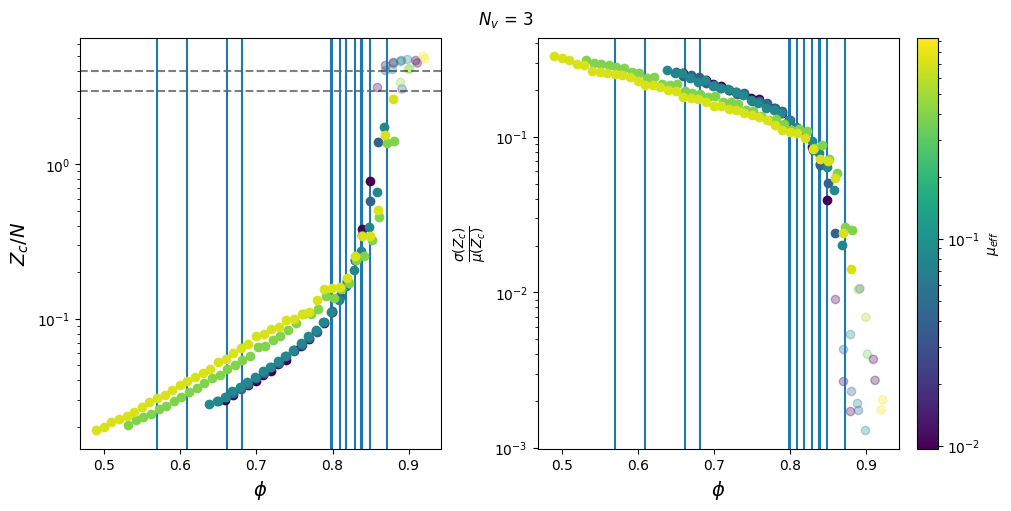

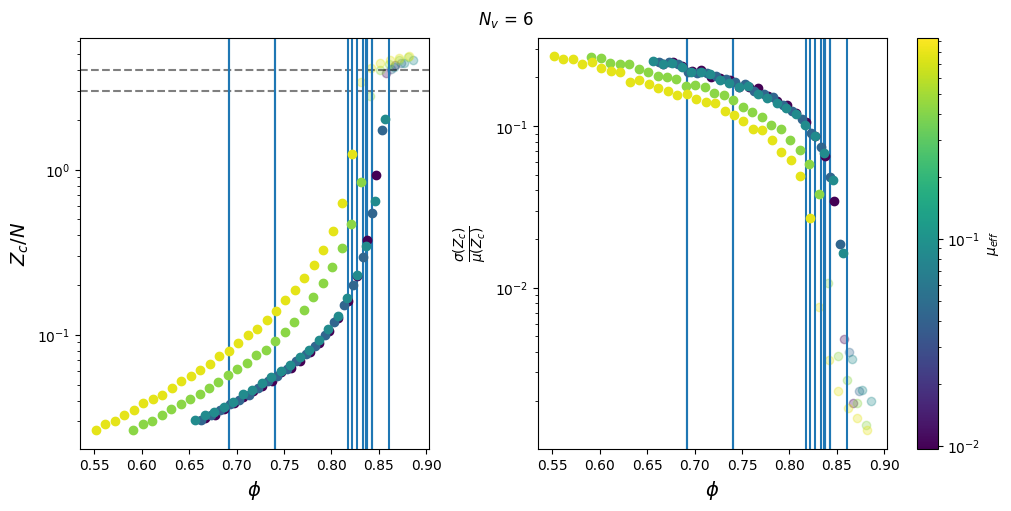

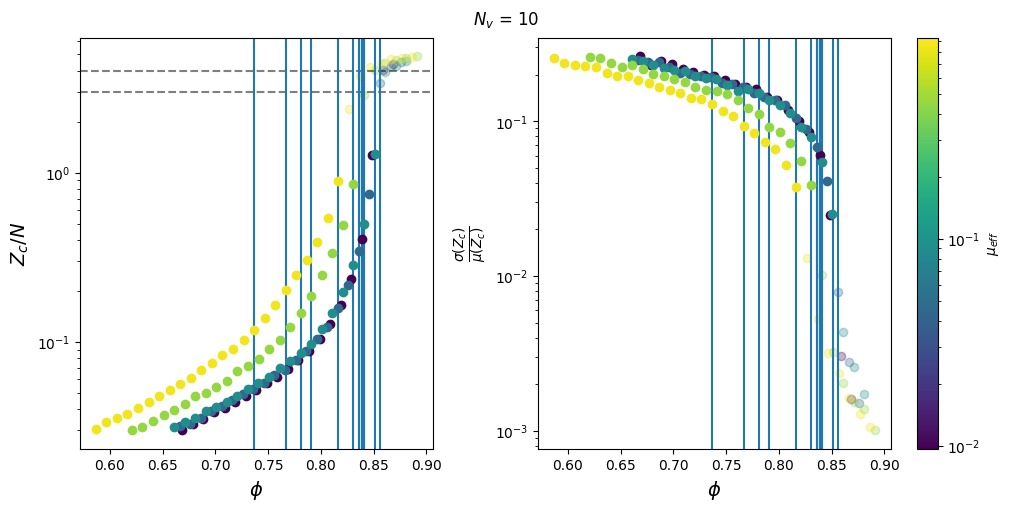

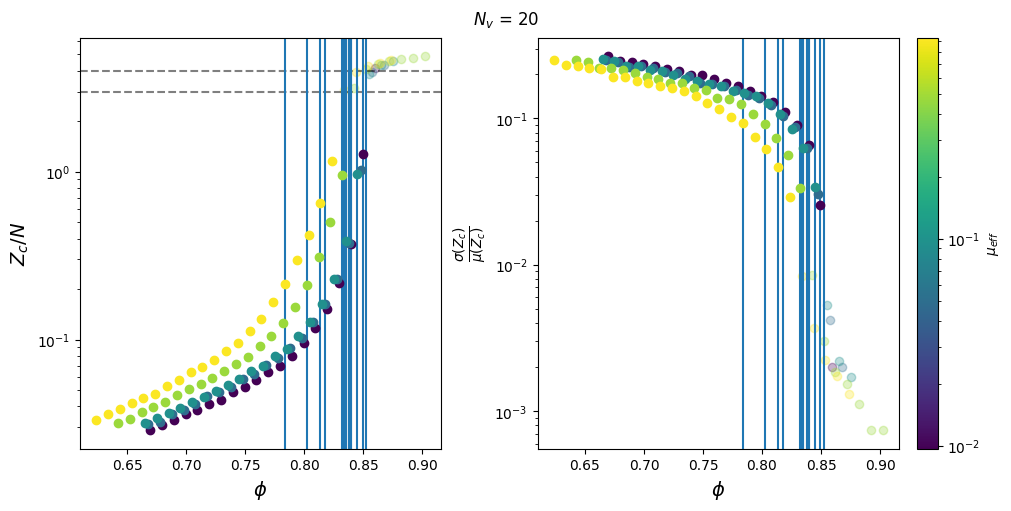

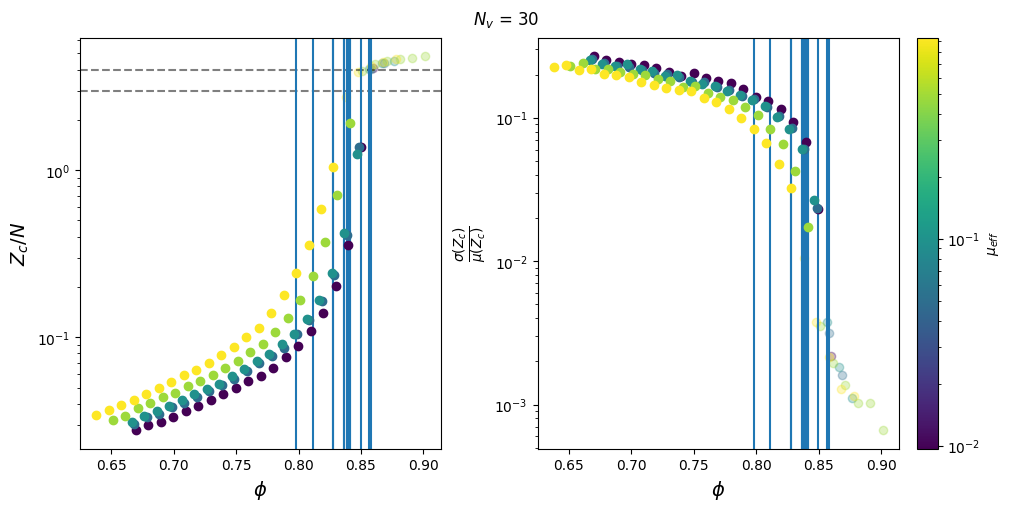

In [22]:
for nv in np.unique(nv_as_array):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        n_contacts_total_global = []
        n_contacts_total_std_global = []
        n_particles_global = []

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)
            n_contacts_total_global.append(contacts_data['n_contacts_total'][i][j])
            n_contacts_total_std_global.append(contacts_data['n_contacts_total_std'][i][j])
            n_particles_global.append(contacts_data['n_particles'][i][j])
        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        phi_global = np.array(phi_global)
        n_contacts_total_global = np.array(n_contacts_total_global)
        n_contacts_total_std_global = np.array(n_contacts_total_std_global)
        n_particles_global = np.array(n_particles_global)

        valid_mask = (phi_global <= phi_max)
        for mask, alpha, zorder in zip([valid_mask, ~valid_mask], [1, 0.3], [10, 0]):
            ax[0].scatter(phi_global[mask], (n_contacts_total_global / n_particles_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].scatter(phi_global[mask], (n_contacts_total_std_global / n_contacts_total_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

        for a in ax:
            a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_b_small.values[0])
            a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_j_eff.values[0])
            a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].outer_phi_j_eff.values[0])

    ax[0].axhline(3, c='k', linestyle='--', alpha=0.5, zorder=0)
    ax[0].axhline(4, c='k', linestyle='--', alpha=0.5, zorder=0)
    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$Z_c / N$', fontsize=14)
    ax[1].set_ylabel(r'$\frac{\sigma(Z_c)}{\mu(Z_c)}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.show()

The NONZERO contact results are the interesting things to look at.  Otherwise, there is a trivial constant increase (i.e. in force or torque) with density.  This constant increase is removed when looking at the NONZERO quantities, which makes it easier to attribute interesting effects to friction that would otherwise be masked by the global phi increase.

Measuring the average of the norm of the torques and forces (across all contacts) shows that in the low friction case, the torques are essentially nonexistent until very large densities.  However, for the high friction cases, the torques have a more gradual rise.  This is not unexpected and likely can be related to $\phi_B$.

Another interesting observation is that the low friction cases for large $N_v$ (anything 20 and up), has a surprisingly large force magnitude.  This could possibly be due to multiple overlaps and may need to be tuned out.

## TODO: Relate rise in torques to $\phi_B$!

## TODO: Determine if the larger force magnitudes for low $\mu_{eff}$ high $N_v$ cases is due to multiple overlaps

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/3087723542.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(phi_global[mask], (abs_torque_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)


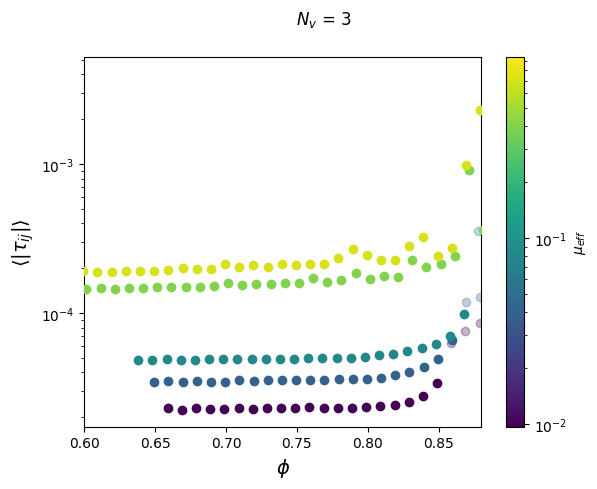

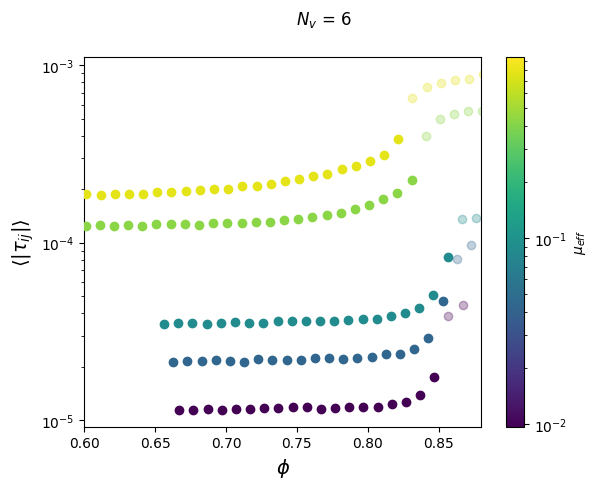

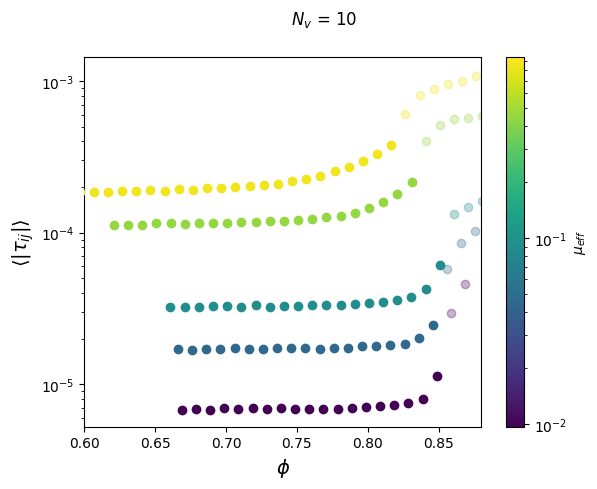

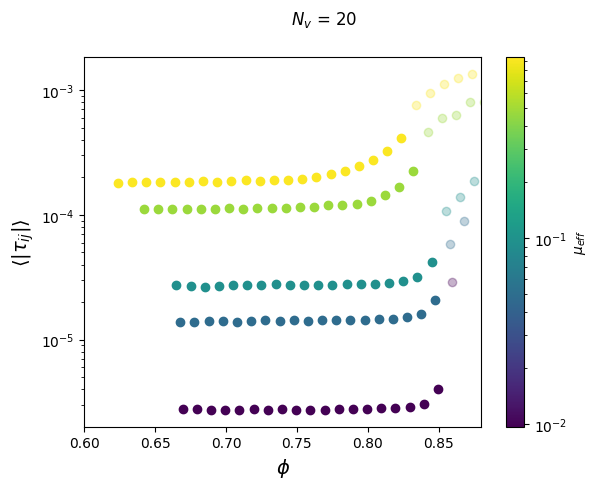

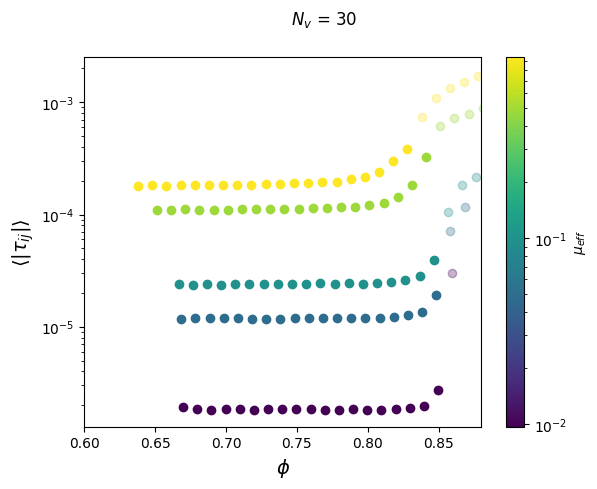

In [90]:
for nv in np.unique(nv_as_array):
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        abs_torque_nonzero_global = []
        force_norm_nonzero_global = []

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)

            force_norm_nonzero = contacts_data['friction_contacts_torques'][i]['force_norm_nonzero'][j]
            force_norm_nonzero_global.append(force_norm_nonzero)

            abs_torque_nonzero = contacts_data['friction_contacts_torques'][i]['abs_torque_nonzero'][j]
            abs_torque_nonzero_global.append(abs_torque_nonzero)

        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        phi_global = np.array(phi_global)
        abs_torque_nonzero_global = np.array(abs_torque_nonzero_global)
        force_norm_nonzero_global = np.array(force_norm_nonzero_global)

        valid_mask = (phi_global <= phi_max)
        for mask, alpha, zorder in zip([valid_mask, ~valid_mask], [1, 0.3], [10, 0]):
            plt.scatter(phi_global[mask], (abs_torque_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

        # for a in ax:
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_b_small.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_j_eff.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].outer_phi_j_eff.values[0])

    plt.yscale('log')
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.xlim(0.6, 0.88)
    plt.ylabel(r'$\langle|\tau_{ij}|\rangle$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/torques/NV-{nv}.png', dpi=600)
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/2290828468.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(phi_global[mask], (force_norm_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)


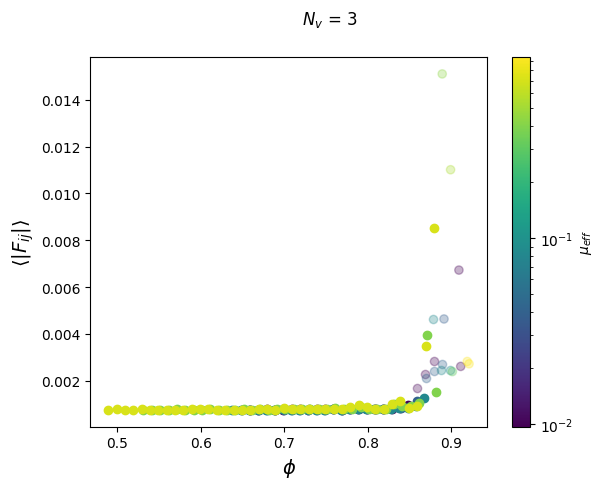

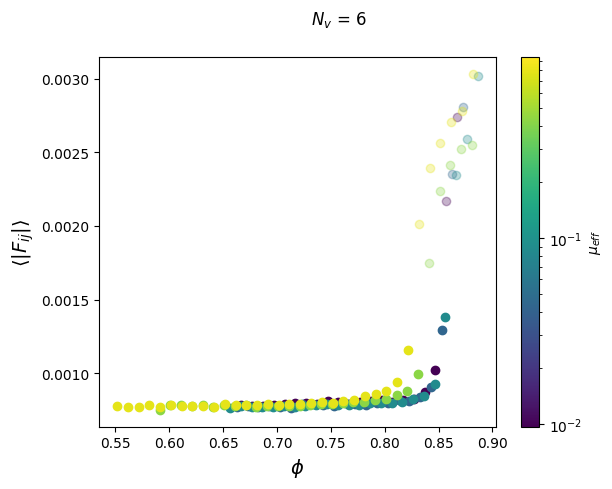

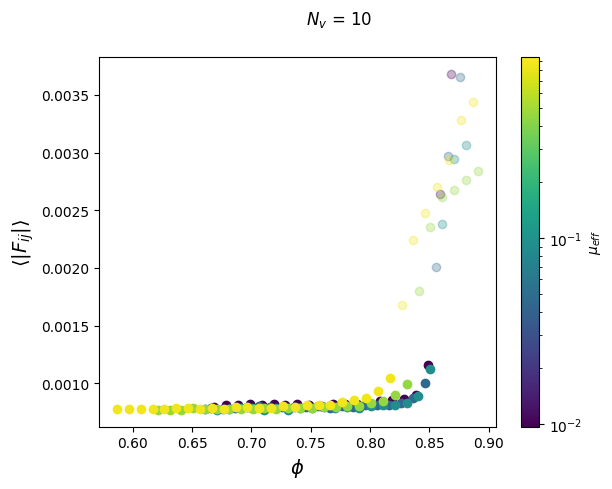

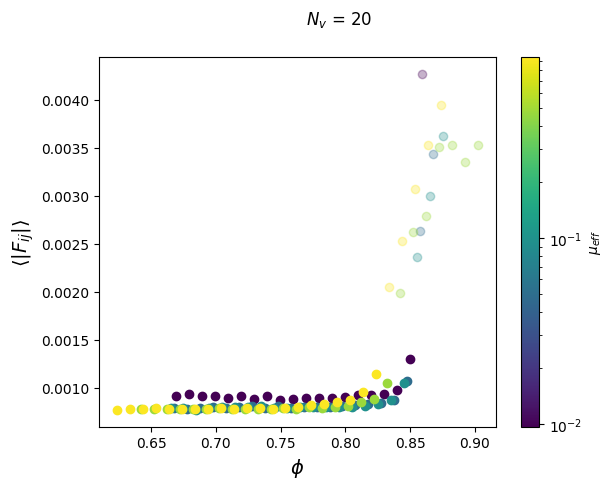

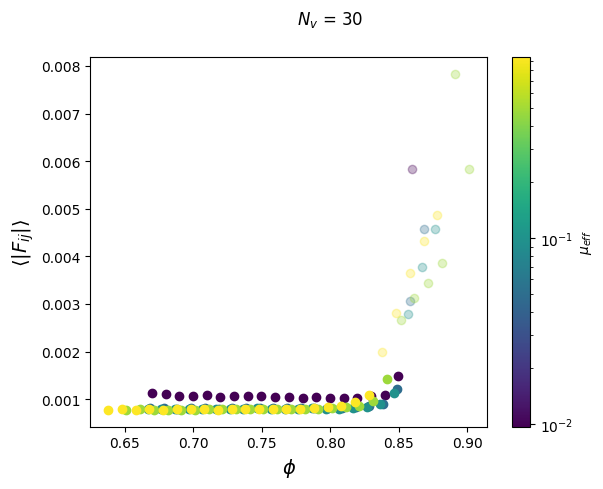

In [89]:
for nv in np.unique(nv_as_array):
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        abs_torque_nonzero_global = []
        force_norm_nonzero_global = []

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)

            force_norm_nonzero = contacts_data['friction_contacts_torques'][i]['force_norm_nonzero'][j]
            force_norm_nonzero_global.append(force_norm_nonzero)

            abs_torque_nonzero = contacts_data['friction_contacts_torques'][i]['abs_torque_nonzero'][j]
            abs_torque_nonzero_global.append(abs_torque_nonzero)

        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        phi_global = np.array(phi_global)
        abs_torque_nonzero_global = np.array(abs_torque_nonzero_global)
        force_norm_nonzero_global = np.array(force_norm_nonzero_global)

        valid_mask = (phi_global <= phi_max)
        for mask, alpha, zorder in zip([valid_mask, ~valid_mask], [1, 0.3], [10, 0]):
            plt.scatter(phi_global[mask], (force_norm_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

        # for a in ax:
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_b_small.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].phi_j_eff.values[0])
            # a.axvline(phi_b_data[(phi_b_data.mu == mu_eff) & (phi_b_data.nv == nv)].outer_phi_j_eff.values[0])

    plt.xlabel(r'$\phi$', fontsize=14)
    plt.ylabel(r'$\langle|F_{ij}|\rangle$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.savefig(f'figures/forces/NV-{nv}.png', dpi=600)
    plt.show()

/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/3455930140.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(phi_global[mask], (abs_torque_std_nonzero_global / abs_torque_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
/var/folders/f5/gw8thzr169xd6l47yn540sf80000gn/T/ipykernel_78623/3455930140.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax

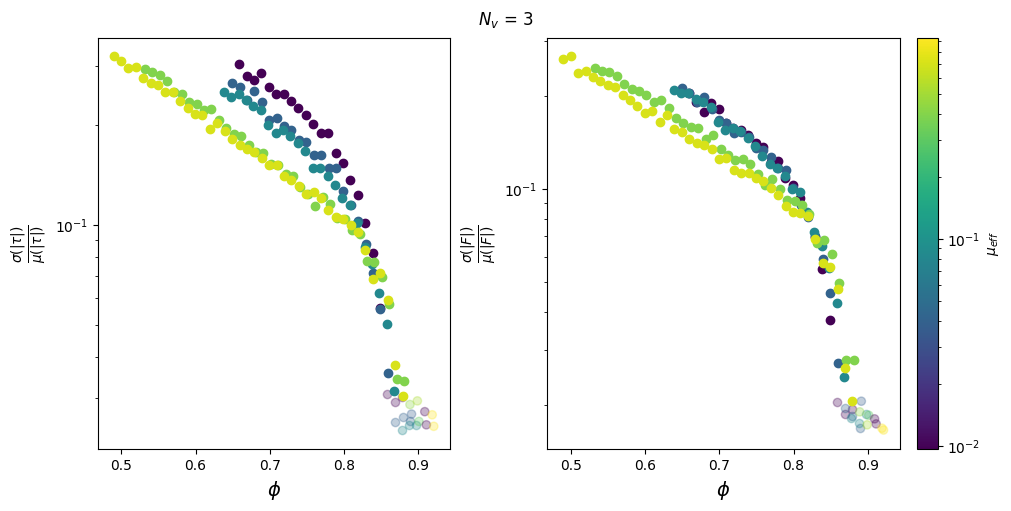

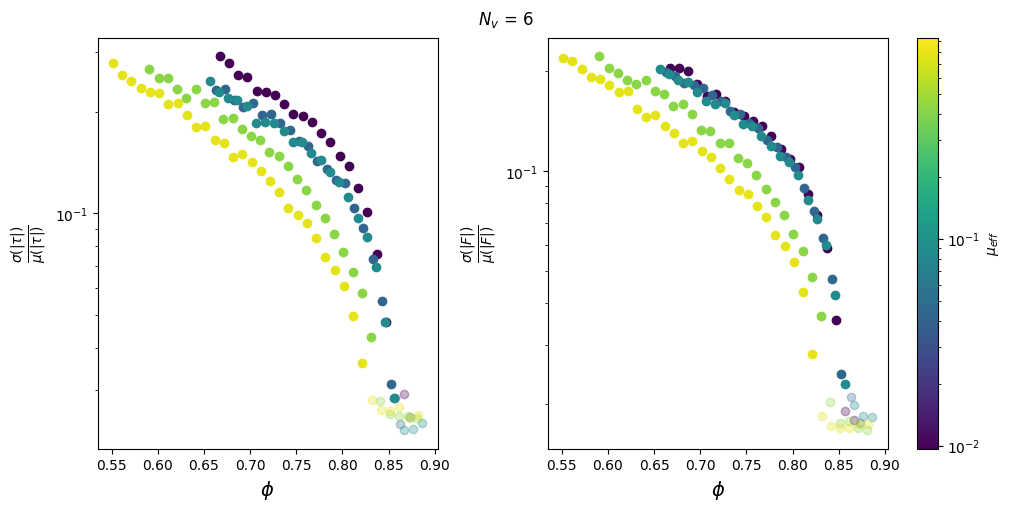

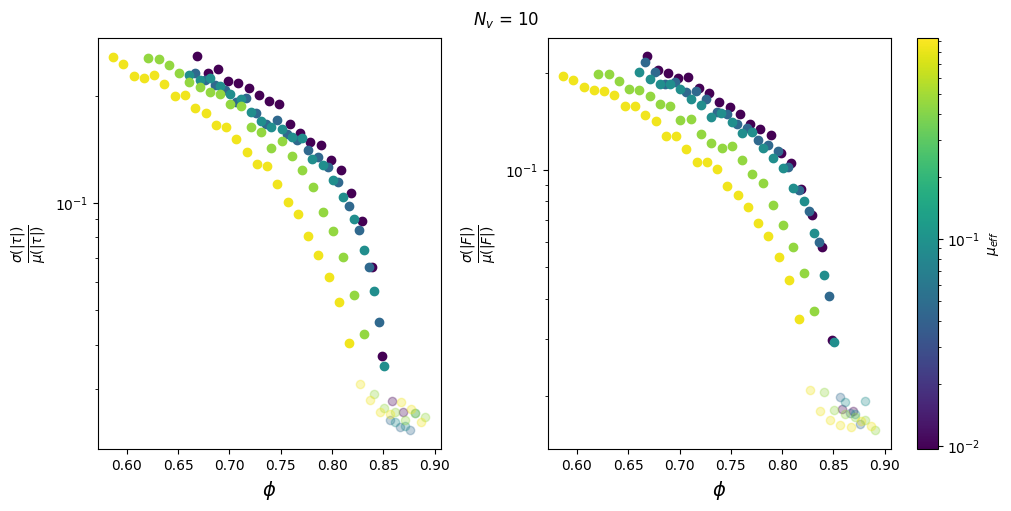

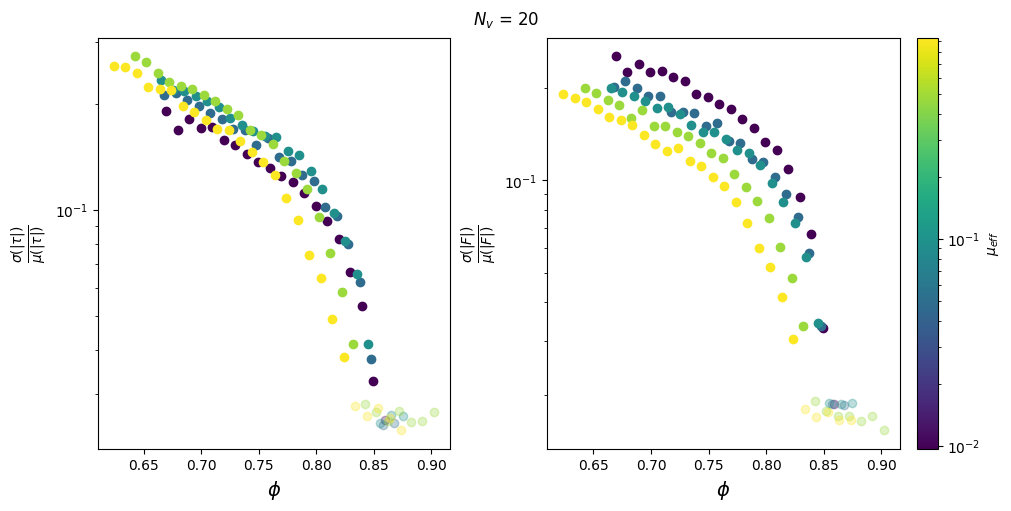

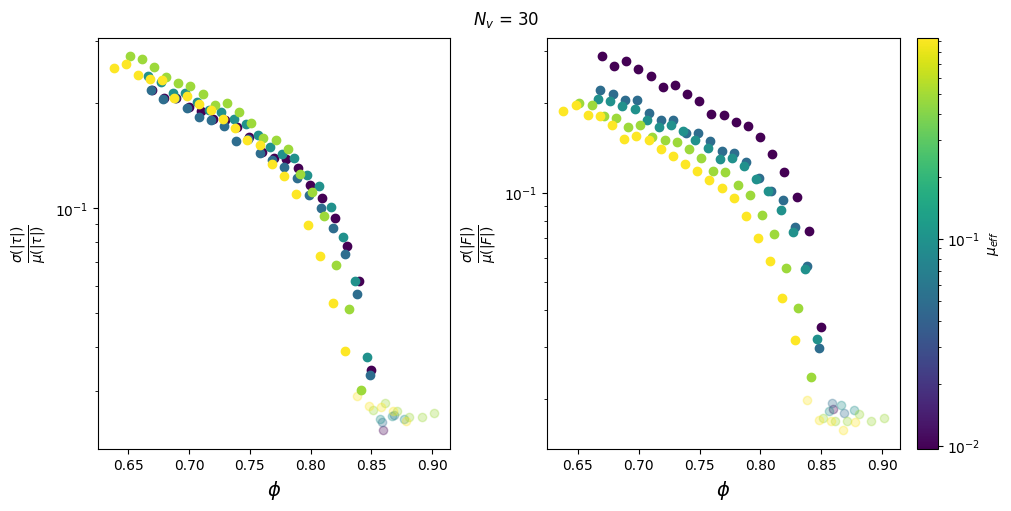

In [24]:
for nv in np.unique(nv_as_array):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)
    for mu_eff in np.unique(mu_as_array[nv_as_array == nv]):
        phi_global = []
        abs_torque_nonzero_global = []
        abs_torque_std_nonzero_global = []
        force_norm_nonzero_global = []
        force_norm_std_nonzero_global = []

        for i in range(len(contacts_data['friction_contacts_torques'])):
            nv_i = contacts_data['nv'][i]
            mu_eff_i = contacts_data['mu_eff'][i]
            if nv not in nv_i or mu_eff not in mu_eff_i:
                continue
            j = np.where((nv_i == nv) & (mu_eff_i == mu_eff))[0][0]
            phi = contacts_data['phi'][i][j]
            phi_global.append(phi)

            force_norm_nonzero = contacts_data['friction_contacts_torques'][i]['force_norm_nonzero'][j]
            force_norm_nonzero_global.append(force_norm_nonzero)

            force_norm_std_nonzero = contacts_data['friction_contacts_torques'][i]['force_norm_std_nonzero'][j]
            force_norm_std_nonzero_global.append(force_norm_std_nonzero)

            abs_torque_nonzero = contacts_data['friction_contacts_torques'][i]['abs_torque_nonzero'][j]
            abs_torque_nonzero_global.append(abs_torque_nonzero)

            abs_torque_std_nonzero = contacts_data['friction_contacts_torques'][i]['abs_torque_std_nonzero'][j]
            abs_torque_std_nonzero_global.append(abs_torque_std_nonzero)

        phi_max = max_overlap_data[(max_overlap_data.nv == nv) & (max_overlap_data.mu_eff == mu_eff)].phi_max.values[0]

        phi_global = np.array(phi_global)
        abs_torque_nonzero_global = np.array(abs_torque_nonzero_global)
        force_norm_nonzero_global = np.array(force_norm_nonzero_global)
        abs_torque_std_nonzero_global = np.array(abs_torque_std_nonzero_global)
        force_norm_std_nonzero_global = np.array(force_norm_std_nonzero_global)

        valid_mask = (phi_global <= phi_max)
        for mask, alpha, zorder in zip([valid_mask, ~valid_mask], [1, 0.3], [10, 0]):
            ax[0].scatter(phi_global[mask], (abs_torque_std_nonzero_global / abs_torque_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)
            ax[1].scatter(phi_global[mask], (force_norm_std_nonzero_global / force_norm_nonzero_global)[mask], c=cmap(mu_eff_norm(mu_eff)), marker='o', alpha=alpha, zorder=zorder)

    for a in ax:
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
    ax[0].set_ylabel(r'$\frac{\sigma(|\tau|)}{\mu(|\tau|)}$', fontsize=14)
    ax[1].set_ylabel(r'$\frac{\sigma(|F|)}{\mu(|F|)}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.show()

# Velocity Autocorrelations